<a href="https://colab.research.google.com/github/dolmani38/Summary2/blob/main/colab_english_model_SAM_WGAN_v3.6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN based Korean summarizer using semi abstractive method


#4. Implementation


## 4.1 기본 설정...

In [1]:
if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!pip install keybert
!pip install sentence-transformers==0.3.0
!pip install transformers==3.0.2

#!pip install sentence-transformers

     |████████████████████████████████| 71kB 5.5MB/s 
     |████████████████████████████████| 1.9MB 9.2MB/s 
     |████████████████████████████████| 890kB 37.8MB/s 
     |████████████████████████████████| 3.2MB 26.7MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.0-cp37-none-any.whl size=86754 sha256=13e05555dfbf16e40557d536fed50c1b11f37a41a2d774e8c475ee80d36ddc88
  Stored in directory: /root/.cache/pip/wheels/b8/23/85/85d6a9a6c68f0625a1ecdaad903bb0a78df058c10cf74f9de4
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=849879a82491d817bc880b499efebf0c0f13769625a2a2ba028620f4059e8022
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses
     |████████████████████████████████| 778kB 10.9MB/s 
     |████████████████████████████████| 3.0MB 24.0MB/s 
     |████████████████████████████████| 1.2MB 22.2MB/s 
  F

In [3]:
import matplotlib.pyplot as plt
# set seeds for reproducability
from numpy.random import seed
seed(1)

import pandas as pd
import numpy as np
import string, os 

import urllib.request
import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
import tensorflow as tf
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('GPU device not found')

Found GPU at: /device:GPU:0


In [5]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [6]:
import random

SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [7]:
# Print iterations progress
class ProgressBar:

    def __init__(self,total=20, prefix = '', suffix = '', decimals = 1, length = 20, fill = '|', printEnd = "\r"):
        self.total = total
        self.prefix = prefix
        self.suffix = suffix
        self.decimals = decimals
        self.length = length
        self.fill = fill
        self.printEnd = printEnd
        self.ite = 0
        self.back_filledLength = 0

    def printProgress(self,iteration, text):
        self.ite += iteration
        percent = ("{0:." + str(self.decimals) + "f}").format(100 * (self.ite / float(self.total)))
        filledLength = int(self.length * self.ite // self.total)
        bar = self.fill * filledLength + '.' * (self.length - filledLength)
        if filledLength > self.back_filledLength or percent == 100:
            print(f'\r{self.prefix} |{bar}| {percent}% {self.suffix}  {text}', end="", flush=True)
            # Print New Line on Complete
            if self.ite == self.total: 
                print()
        self.back_filledLength = filledLength    

In [8]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

## CNN/Daily Mail dataset download...

In [9]:
import tensorflow_datasets as tfds
train_data, test_data = tfds.load(name="cnn_dailymail",split=(tfds.Split.TRAIN,tfds.Split.TEST),with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incompleteIEQH52/cnn_dailymail-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incompleteIEQH52/cnn_dailymail-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incompleteIEQH52/cnn_dailymail-test.tfrecord


Dataset cnn_dailymail downloaded and prepared to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0. Subsequent calls will reuse this data.


In [10]:
train_data[0]

<PrefetchDataset shapes: {article: (), highlights: ()}, types: {article: tf.string, highlights: tf.string}>

In [11]:
sentences_dataset = []
gold_summary = []
iterator = iter(train_data[0])
cnt = 0
for data in iterator:
    cnt += 1
    if cnt < 1000:
        sentences_dataset.append(data['article'].numpy().decode('UTF-8'))
        gold_summary.append(data['highlights'].numpy().decode('UTF-8'))
    else:
        break

In [12]:
print(len(sentences_dataset))

999


##4.2 Grammar Discriminator Class

In [13]:
from transformers import BertTokenizer, AutoTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split

import time
import random
import datetime

# 간단한 전처리
def clean_text(txt):
    txt = txt.replace('\n',' ')
    txt = txt.replace('\r',' ')    
    txt = txt.replace('=','')
    txt = txt.replace('\"','')   
    txt = txt.replace('\'','')
    #txt = txt.replace(',','')
    txt = txt.replace('..','')
    txt = txt.replace('...','')
    txt = txt.replace(' .','.')
    txt = txt.replace('.','. ')
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')           
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')             
    return txt.strip()

def shuffling(txt):
    txt_list = txt.split(' ')
    random.shuffle(txt_list)
    return ' '.join(txt_list)

def collect_training_dataset_for_grammar_discriminator(sentences_dataset):

    sentences = []
    labels = []

    for txtss in sentences_dataset:
        txtss = clean_text(txtss)
        txts = txtss.strip().split('.')
        for txt in txts:  
            txt = txt.strip()
            if len(txt) > 40:
                #ko_grammar_dataset.append([txt,1])
                txt = txt.replace('.','')
                tf = random.choice([True,False])
                # 정상 또는 비정상 둘중에 하나만 데이터셋에 추가
                if (tf):
                    sentences.append(txt) # '.'의 위치를 보고 True, False를 판단 하기 땜에...
                    labels.append(1)
                else:
                    sentences.append(shuffling(txt))
                    labels.append(0)

    return sentences,labels

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

class Grammar_Discriminator:


    def __init__(self, pre_trained_model_name='bert-base-uncased', input_dir=None):

        if input_dir is None:
            print('Loading BERT tokenizer...')
            self.tokenizer = BertTokenizer.from_pretrained(pre_trained_model_name, do_lower_case=True)
            self.discriminator = BertForSequenceClassification.from_pretrained(
                                    pre_trained_model_name, # Use the 12-layer BERT model, with an uncased vocab.
                                    num_labels = 2, # The number of output labels--2 for binary classification.
                                                    # You can increase this for multi-class tasks.   
                                    output_attentions = False, # Whether the model returns attentions weights.
                                    output_hidden_states = False, # Whether the model returns all hidden-states.
                                )            
        else:
            self.__load_model(input_dir)



    def set_dataset(self, sentences,labels):
        # Print the original sentence.
        print(' Original: ', sentences[0])

        # Print the sentence split into tokens.
        print('Tokenized: ', self.tokenizer.tokenize(sentences[0]))

        # Print the sentence mapped to token ids.
        print('Token IDs: ', self.tokenizer.convert_tokens_to_ids(self.tokenizer.tokenize(sentences[0])))   

        # Tokenize all of the sentences and map the tokens to thier word IDs.
        input_ids = []
        attention_masks = []

        # For every sentence...
        for sent in sentences:
            # `encode_plus` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            #   (5) Pad or truncate the sentence to `max_length`
            #   (6) Create attention masks for [PAD] tokens.
            encoded_dict = self.tokenizer.encode_plus(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = 64,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                                truncation = True,
                        )
            
            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict['input_ids'])
            
            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])

        # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        labels = torch.tensor(labels)

        # Print sentence 0, now as a list of IDs.
        print('Original: ', sentences[0])
        print('Token IDs:', input_ids[0])

        # Training & Validation Split
        # Divide up our training set to use 90% for training and 10% for validation.

        # Combine the training inputs into a TensorDataset.
        dataset = TensorDataset(input_ids, attention_masks, labels)

        # Create a 90-10 train-validation split.

        # Calculate the number of samples to include in each set.
        train_size = int(0.9 * len(dataset))
        val_size = len(dataset) - train_size

        # Divide the dataset by randomly selecting samples.
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        print('{:>5,} training samples'.format(train_size))
        print('{:>5,} validation samples'.format(val_size))

        # The DataLoader needs to know our batch size for training, so we specify it 
        # here. For fine-tuning BERT on a specific task, the authors recommend a batch 
        # size of 16 or 32.
        self.batch_size = 32

        # Create the DataLoaders for our training and validation sets.
        # We'll take training samples in random order. 
        self.train_dataloader = DataLoader(
                    train_dataset,  # The training samples.
                    sampler = RandomSampler(train_dataset), # Select batches randomly
                    batch_size = self.batch_size # Trains with this batch size.
                )

        # For validation the order doesn't matter, so we'll just read them sequentially.
        self.validation_dataloader = DataLoader(
                    val_dataset, # The validation samples.
                    sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                    batch_size = self.batch_size # Evaluate with this batch size.
                )        



    def train(self,epochs=4):
        # Tell pytorch to run this model on the GPU.
        self.discriminator.cuda()

        # Get all of the model's parameters as a list of tuples.
        params = list(self.discriminator.named_parameters())

        print('The BERT model has {:} different named parameters.\n'.format(len(params)))

        print('==== Embedding Layer ====\n')

        for p in params[0:5]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

        print('\n==== First Transformer ====\n')

        for p in params[5:21]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

        print('\n==== Output Layer ====\n')

        for p in params[-4:]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))  

        # Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
        # I believe the 'W' stands for 'Weight Decay fix"
        self.optimizer = AdamW(self.discriminator.parameters(),
                        lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                        eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                        )

        # Number of training epochs. The BERT authors recommend between 2 and 4. 
        # We chose to run for 4, but we'll see later that this may be over-fitting the
        # training data.
        #epochs = 2

        # Total number of training steps is [number of batches] x [number of epochs]. 
        # (Note that this is not the same as the number of training samples).
        total_steps = len(self.train_dataloader) * epochs

        # Create the learning rate scheduler.
        scheduler = get_linear_schedule_with_warmup(self.optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)
            
        # This training code is based on the `run_glue.py` script here:
        # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

        # Set the seed value all over the place to make this reproducible.
        seed_val = 42

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)

        # We'll store a number of quantities such as training and validation loss, 
        # validation accuracy, and timings.
        training_stats = []

        # Measure the total training time for the whole run.
        total_t0 = time.time()

        # For each epoch...
        for epoch_i in range(0, epochs):
            
            # ========================================
            #               Training
            # ========================================
            
            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            print('Training...')

            # Measure how long the training epoch takes.
            t0 = time.time()

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode. Don't be mislead--the call to 
            # `train` just changes the *mode*, it doesn't *perform* the training.
            # `dropout` and `batchnorm` layers behave differently during training
            # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
            self.discriminator.train()

            # For each batch of training data...
            for step, batch in enumerate(self.train_dataloader):

                # Progress update every 40 batches.
                if step % 40 == 0 and not step == 0:
                    # Calculate elapsed time in minutes.
                    elapsed = format_time(time.time() - t0)
                    
                    # Report progress.
                    print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(self.train_dataloader), elapsed))

                # Unpack this training batch from our dataloader. 
                #
                # As we unpack the batch, we'll also copy each tensor to the GPU using the 
                # `to` method.
                #
                # `batch` contains three pytorch tensors:
                #   [0]: input ids 
                #   [1]: attention masks
                #   [2]: labels 
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)

                # Always clear any previously calculated gradients before performing a
                # backward pass. PyTorch doesn't do this automatically because 
                # accumulating the gradients is "convenient while training RNNs". 
                # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
                self.discriminator.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # It returns different numbers of parameters depending on what arguments
                # arge given and what flags are set. For our useage here, it returns
                # the loss (because we provided labels) and the "logits"--the model
                # outputs prior to activation.
                loss, logits = self.discriminator(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask, 
                                    labels=b_labels)

                # Accumulate the training loss over all of the batches so that we can
                # calculate the average loss at the end. `loss` is a Tensor containing a
                # single value; the `.item()` function just returns the Python value 
                # from the tensor.
                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Clip the norm of the gradients to 1.0.
                # This is to help prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), 1.0)

                # Update parameters and take a step using the computed gradient.
                # The optimizer dictates the "update rule"--how the parameters are
                # modified based on their gradients, the learning rate, etc.
                self.optimizer.step()

                # Update the learning rate.
                scheduler.step()

            # Calculate the average loss over all of the batches.
            avg_train_loss = total_train_loss / len(self.train_dataloader)            
            
            # Measure how long this epoch took.
            training_time = format_time(time.time() - t0)

            print("")
            print("  Average training loss: {0:.2f}".format(avg_train_loss))
            print("  Training epcoh took: {:}".format(training_time))
                
            # ========================================
            #               Validation
            # ========================================
            # After the completion of each training epoch, measure our performance on
            # our validation set.

            print("")
            print("Running Validation...")

            t0 = time.time()

            # Put the model in evaluation mode--the dropout layers behave differently
            # during evaluation.
            self.discriminator.eval()

            # Tracking variables 
            total_eval_accuracy = 0
            total_eval_loss = 0
            nb_eval_steps = 0

            # Evaluate data for one epoch
            for batch in self.validation_dataloader:
                
                # Unpack this training batch from our dataloader. 
                #
                # As we unpack the batch, we'll also copy each tensor to the GPU using 
                # the `to` method.
                #
                # `batch` contains three pytorch tensors:
                #   [0]: input ids 
                #   [1]: attention masks
                #   [2]: labels 
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)
                
                # Tell pytorch not to bother with constructing the compute graph during
                # the forward pass, since this is only needed for backprop (training).
                with torch.no_grad():        

                    # Forward pass, calculate logit predictions.
                    # token_type_ids is the same as the "segment ids", which 
                    # differentiates sentence 1 and 2 in 2-sentence tasks.
                    # The documentation for this `model` function is here: 
                    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                    # Get the "logits" output by the model. The "logits" are the output
                    # values prior to applying an activation function like the softmax.
                    (loss, logits) = self.discriminator(b_input_ids, 
                                        token_type_ids=None, 
                                        attention_mask=b_input_mask,
                                        labels=b_labels)
                    
                # Accumulate the validation loss.
                total_eval_loss += loss.item()

                # Move logits and labels to CPU
                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()

                # Calculate the accuracy for this batch of test sentences, and
                # accumulate it over all batches.
                total_eval_accuracy += flat_accuracy(logits, label_ids)
                

            # Report the final accuracy for this validation run.
            avg_val_accuracy = total_eval_accuracy / len(self.validation_dataloader)
            print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

            # Calculate the average loss over all of the batches.
            avg_val_loss = total_eval_loss / len(self.validation_dataloader)
            
            # Measure how long the validation run took.
            validation_time = format_time(time.time() - t0)
            
            print("  Validation Loss: {0:.2f}".format(avg_val_loss))
            print("  Validation took: {:}".format(validation_time))

            # Record all statistics from this epoch.
            training_stats.append(
                {
                    'epoch': epoch_i + 1,
                    'Training Loss': avg_train_loss,
                    'Valid. Loss': avg_val_loss,
                    'Valid. Accur.': avg_val_accuracy,
                    'Training Time': training_time,
                    'Validation Time': validation_time
                }
            )

        print("")
        print("Training complete!")

        print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
            

        return training_stats

    def save_model(self, output_dir = './model_save/'):
        # Create output directory if needed
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        print("Saving model to %s" % output_dir)

        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = self.discriminator.module if hasattr(self.discriminator, 'module') else self.discriminator  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        self.tokenizer.save_pretrained(output_dir)

        # Good practice: save your training arguments together with the trained model
        # torch.save(args, os.path.join(output_dir, 'training_args.bin'))

    def __load_model(self, input_dir = './drive/MyDrive/Colab Notebooks/summary/en_grammar_check_model'):
        print('Loading BERT tokenizer...')
        self.tokenizer = BertTokenizer.from_pretrained(input_dir)
        self.discriminator = BertForSequenceClassification.from_pretrained(input_dir)

    def transfer_learning(self, sentences, train_for = True):
        
        input_ids = []
        attention_masks = []

        # For every sentence...
        for sent in sentences:
            # `encode_plus` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            #   (5) Pad or truncate the sentence to `max_length`
            #   (6) Create attention masks for [PAD] tokens.
            encoded_dict = self.tokenizer.encode_plus(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = 64,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                                truncation = True,
                        )
            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict['input_ids'])

            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])
        
        if train_for:
            b_labels = torch.ones(len(sentences),dtype=torch.long).to(device)
        else:
            b_labels = torch.zeros(len(sentences),dtype=torch.long).to(device)
        #print(b_labels)
        # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0).to(device)
        attention_masks = torch.cat(attention_masks, dim=0).to(device)    
        #if str(discriminator1.device) == 'cpu':
        #    pass
        #else:
        #    input_ids = input_ids.to(device)
        #    attention_masks = attention_masks.to(device)        

        loss, logits = self.discriminator(input_ids, 
                            token_type_ids=None, 
                            attention_mask=attention_masks, 
                                labels=b_labels)
        #return torch.sigmoid(outputs[0][:,1])
        #return outputs[0][:,1]
        return loss, logits


###4.2.1 CNN/Daily Mail dataset으로 영어 문법 학습

In [14]:
sentences,labels = collect_training_dataset_for_grammar_discriminator(sentences_dataset[0:1])

In [15]:
sentences_dataset[0]

"By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained 

In [16]:
k=5
print(labels[k])
print(sentences[k])

0
last newly The a for says attending in while he contaminated food the Italy through diocese conference infection bishops month contracted ordained


In [17]:
len(sentences_dataset)

999

In [18]:
use_pretrained_model = True

if use_pretrained_model:
    g_discriminator = Grammar_Discriminator(input_dir = '/content/drive/MyDrive/Colab Notebooks/summary/model_save')
else:
    sentences,labels = collect_training_dataset_for_grammar_discriminator(sentences_dataset)
    print(len(sentences))
    g_discriminator = Grammar_Discriminator()
    g_discriminator.set_dataset(sentences[0:500000],labels[0:500000])
    g_discriminator.train(epochs=2)
    g_discriminator.save_model()

Loading BERT tokenizer...


In [19]:
if False: ## 추가적인 fine-tuning
    sentences,labels = collect_training_dataset_for_grammar_discriminator(sentences_dataset)
    print(len(sentences))
    g_discriminator = Grammar_Discriminator()
    g_discriminator.set_dataset(sentences[0:500000],labels[0:500000])
    g_discriminator.train(epochs=1)
    g_discriminator.save_model()

##4.3 Static similarity discriminator class

In [20]:
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
import scipy


class Similarity_Discriminator:
    '''
    _instance = None
    _embedder = None
    def __new__(cls,pre_trained_model_name='stsb-roberta-large'):
        if cls._instance is None:
            print('Creating Similarity_Discriminator object')
            cls._instance = super(Similarity_Discriminator, cls).__new__(cls)
            # Put any initialization here.
            cls._embedder = SentenceTransformer(pre_trained_model_name)
        return cls._instance

    '''

    def __init__(self,pre_trained_model_name='stsb-roberta-large'):
        print('Creating Similarity_Discriminator object')
        # Put any initialization here.
        self._embedder = SentenceTransformer(pre_trained_model_name)  
        #self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)

    def encode(self,texts):
        return self._embedder.encode(texts,show_progress_bar=False)

    def similarity(self, query_text, org_text_emb):
        queries = nltk.sent_tokenize(query_text)
        query_embeddings = self._embedder.encode(queries,show_progress_bar=False)
        #query_embeddings = self._embedder.encode(queries,show_progress_bar=False)
        #print(queries)
        #print(org_text_emb)
        
        if len(query_embeddings) == 0:
            return 0.0

        cos_scores = scipy.spatial.distance.cdist(query_embeddings, org_text_emb, "cosine")
        similarity_score = 1.0 - np.mean(np.min(cos_scores,axis=0))
        '''
        for query, query_embedding in zip(queries, query_embeddings):
            distances = scipy.spatial.distance.cdist([query_embedding], [org_text_emb], "cosine")[0]
            results = zip(range(len(distances)), distances)
            for idx, distance in results:
                scores.append(1-distance)
        '''
        return similarity_score  
 

###4.3.1 영어 문장 유사도 pre-trained model 적용

In [21]:
s_discriminator = Similarity_Discriminator(pre_trained_model_name="stsb-bert-base")
#s_discriminator = Similarity_Discriminator()

Creating Similarity_Discriminator object


100%|██████████| 405M/405M [00:11<00:00, 35.2MB/s]


##4.4 Document source class

###4.4.1 keyBERT를 위한 pre-trained model의 적재

In [22]:
#!pip install keybert

In [23]:
#from keybert import KeyBERT
#key_model = KeyBERT('distilbert-base-nli-mean-tokens')

###4.4.2 frame term 추출을 위한 source class 구현

In [24]:


class Source:

    def __init__(self,org_text):
        self.org_text = org_text

    def __crean_text(self, txt):
        txt = txt.replace('\n',' ')
        txt = txt.replace('\r',' ')    
        txt = txt.replace('=','')
        txt = txt.replace('\"','')   
        txt = txt.replace('\'','')
        #txt = txt.replace(',','')
        txt = txt.replace('..','')
        txt = txt.replace('...','')
        txt = txt.replace(' .','.')
        txt = txt.replace('.','. ')
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        return txt.strip()


    def extract_keywords(self,s_discriminator,key_model,comp_rate=0.2):
        self.org_text = self.__crean_text(self.org_text.strip())
        print('------------------------------------------------------------------')
        print(self.org_text)
        print('------------------------------------------------------------------')
        self.org_sentences = np.array(nltk.sent_tokenize(self.org_text))
        self.org_term_set = (' ' + self.org_text + ' ').split(' ')
        self.org_source_length = len(self.org_term_set)
        self.term_table = {}
        #morp_table = {}
        index_table = {}
        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word
        '''
        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code     Token     ')
        for k in self.term_table.keys():
            print( f'  {str(k).ljust(5)}     {self.term_table[k]}')
        print('---------------------------------------------')
        '''
        self.s_discriminator = s_discriminator
        # 원문의 embedding...
        self.org_text_emb = self.s_discriminator.encode(self.org_sentences)
        '''
        # weight 들의 초기화
        terms = np.array(list(self.term_table.values()))

        word_filters=np.array([[0]])

        story_weights = np.zeros(self.org_source_length,)
        word_weights = np.zeros(self.org_source_length,)

        #terms = np.array(list(self.term_table.values()))

        # story에 지배적인 word를 찾는다.
        # 먼저 word의 강세 분석
        for filter in word_filters:
            #print(filter)
            last_idx = len(terms)-(max(filter)+1)
            pb = ProgressBar(last_idx,prefix='Frame token scan:')
            for conv in range(last_idx,0,-1):
                pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                t = np.array(filter) + conv
                part_sen = ' '.join(terms[t]) 
                #print('\n part_sen:',part_sen)
                score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                word_weights[t] += score 

        # story의 강세 분석
        for filter in story_filters:
            #print(filter)
            last_idx = len(terms)-(max(filter)+1)
            pb = ProgressBar(last_idx,prefix='Frame token scan:')
            for conv in range(last_idx,0,-1):
                pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                t = np.array(filter) + conv
                part_sen = ' '.join(terms[t]) 
                score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                story_weights[t] += score

        #각각의 peak를 산출
        word_peaks, _ = find_peaks(word_weights, height=0)
        story_peaks, _ = find_peaks(story_weights, height=0)

        #두개의 peak가 겹치는 word에 대해 한개 word가 유사도에 미치는 영향이 큰것으로 간주
        #해당 word를 유사도 판단 필터에서 제외하고 다시 필터링...
        #이를 통해 story에 대한 word를 최대한 추출 한다.

        dup_order = []
        for i in range(self.org_source_length):
            #lst = ""
            if (i in word_peaks) and (i in story_peaks):
                if terms[i].endswith('.'):
                    pass
                else:
                    dup_order.append(i)
                    
        # Story에 대한 weight을 추출하기 위해, word에 유독 강세가 있는 term을 제외 시킨다.
        print('Negative tokens:',terms[dup_order])
        '''

        top_n = int(len(self.term_table) * comp_rate)

        self.story_peaks = []
        keywords = key_model.extract_keywords(self.org_text,top_n=top_n)
        #print('keywords len',len(keywords))
        #print('keywords',keywords)
        for keyword,p in keywords:
            for k in self.term_table.keys():
                if self.term_table[k] == keyword: # and k not in dup_order:
                    self.story_peaks.append(k)

        self.story_peaks.append(len(self.term_table)-2)
        self.story_peaks = np.sort(np.asarray(self.story_peaks))
        print('story_peaks:',self.story_peaks)
        print('Peak count:',len(self.story_peaks))          


        # story skeleton 추출
        self.frame_text = ""
        for k in self.story_peaks:
            #print(k,term_weight[k],word_table[k])
            self.frame_text += self.term_table[k]+' '  

        print('Frame tokens:',self.frame_text)
        print('')
        print(f'Similarity : {self.s_discriminator.similarity(self.frame_text.strip(),self.org_text_emb)}')    

    def set_key_rate(self,s_discriminator,comp_rate=0.2):
        self.org_text = self.__crean_text(self.org_text.strip())
        print('------------------------------------------------------------------')
        print(self.org_text)
        print('------------------------------------------------------------------')
        self.org_sentences = np.array(nltk.sent_tokenize(self.org_text))
        self.org_term_set = (' ' + self.org_text + ' ').split(' ')
        self.org_source_length = len(self.org_term_set)
        self.term_table = {}
        #morp_table = {}

        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word

        self.s_discriminator = s_discriminator
        # 원문의 embedding...
        self.org_text_emb = self.s_discriminator.encode(self.org_sentences)
        top_n = int(len(self.term_table) * comp_rate)
        #print('top_n',top_n)
        self.story_peaks = [i+1 for i in range(top_n)]

    def analysis_frame_terms(self,s_discriminator,story_filters=np.array([[0,1],[0,1,2],[0,1,2,3]]),peak_base_line = 0.0,comp_rate=0.2,except_key=True,display=False):

        self.org_text = self.__crean_text(self.org_text.strip())
        print('------------------------------------------------------------------')
        print(self.org_text)
        print('------------------------------------------------------------------')
        self.org_sentences = np.array(nltk.sent_tokenize(self.org_text))
        self.org_term_set = (' ' + self.org_text + ' ').split(' ')
        self.org_source_length = len(self.org_term_set)
        self.term_table = {}
        #morp_table = {}

        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word
        '''
        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code     Token     ')
        for k in self.term_table.keys():
            print( f'  {str(k).ljust(5)}     {self.term_table[k]}')
        print('---------------------------------------------')
        '''

        self.s_discriminator = s_discriminator
        # 원문의 embedding...
        self.org_text_emb = self.s_discriminator.encode(self.org_sentences)

        # weight 들의 초기화
        terms = np.array(list(self.term_table.values()))

        word_filters=np.array([[0]])

        story_weights = np.zeros(self.org_source_length,)
        word_weights = np.zeros(self.org_source_length,)

        #terms = np.array(list(self.term_table.values()))

        if except_key:
            # story에 지배적인 word를 찾는다.
            # 먼저 word의 강세 분석
            for filter in word_filters:
                #print(filter)
                last_idx = len(terms)-(max(filter)+1)
                pb = ProgressBar(last_idx,prefix='Frame token scan:')
                for conv in range(last_idx,0,-1):
                    pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                    t = np.array(filter) + conv
                    part_sen = ' '.join(terms[t]) 
                    score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                    word_weights[t] += score 

            # story의 강세 분석
            for filter in story_filters:
                #print(filter)
                last_idx = len(terms)-(max(filter)+1)
                pb = ProgressBar(last_idx,prefix='Frame token scan:')
                for conv in range(last_idx,0,-1):
                    pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                    t = np.array(filter) + conv
                    part_sen = ' '.join(terms[t]) 
                    score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                    story_weights[t] += score

            #각각의 peak를 산출
            word_peaks, _ = find_peaks(word_weights, height=0)
            story_peaks, _ = find_peaks(story_weights, height=0)

            #두개의 peak가 겹치는 word에 대해 한개 word가 유사도에 미치는 영향이 큰것으로 간주
            #해당 word를 유사도 판단 필터에서 제외하고 다시 필터링...
            #이를 통해 story에 대한 word를 최대한 추출 한다.

            dup_order = []
            for i in range(self.org_source_length):
                #lst = ""
                if (i in word_peaks) and (i in story_peaks):
                    if terms[i].endswith('.'):
                        pass
                    else:
                        dup_order.append(i)
                        
            # Story에 대한 weight을 추출하기 위해, word에 유독 강세가 있는 term을 제외 시킨다.
            print('Negative tokens:',terms[dup_order])
            if except_key:
                terms[dup_order] = '---'
        '''
        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code         Token      ')
        print('')
        for index, word in zip(range(len(terms)),terms):
            print( f'  {str(index).ljust(8)}    {word}')
        print('---------------------------------------------')
        '''
        self.story_weights = np.zeros(self.org_source_length,)
        # 그리고 다시 story 분석 스캔
        for filter in story_filters:
            #print(filter)
            last_idx = len(terms)-(max(filter)+1)
            pb = ProgressBar(last_idx,prefix='Frame token scan:')
            for conv in range(last_idx):
                pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                t = np.array(filter) + conv
                part_sen = ' '.join(terms[t]) 
                #part_sen = part_sen.replace('소녀','---')
                score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                self.story_weights[t] += score        


        # base line
        base_line = peak_base_line
        # 다시 peak 추출
        story_peaks, _ = find_peaks(self.story_weights, height=base_line)

        top_n = int(len(self.term_table) * comp_rate)

        if len(story_peaks) > top_n:
            peak_dict = {}
            for i,peak in zip(range(len(story_peaks)),story_peaks):
                peak_dict[peak] = self.story_weights[peak]
            #print(peak_dict)
            peaks = sorted(peak_dict, key=peak_dict.get, reverse=True)
            #print(peaks)
            peaks = peaks[:top_n]
            #print(peaks)
            peaks.sort()
            story_peaks = peaks
            #print(story_peaks)

        #print('top_n:',top_n,'story_peaks:',len(story_peaks))
        #print(story_peaks)
        
        self.story_peaks = np.append(story_peaks,len(story_weights)-2)
        #print(self.story_peaks)
        # story density 표출
        if display:
            plt.figure(figsize=(12, 6))
            plt.plot(self.story_weights)
            plt.plot(self.story_peaks, self.story_weights[self.story_peaks], "x")
            plt.plot(np.zeros_like(self.story_weights)+base_line, "--", color="gray")
            plt.show() 
        print('Peak count:',len(self.story_peaks))          


        # story skeleton 추출
        self.frame_text = ""
        for k in self.story_peaks:
            #print(k,term_weight[k],word_table[k])
            self.frame_text += self.term_table[k]+' '  

        print('Frame tokens:',self.frame_text)
        print('')
        print(f'Similarity : {self.s_discriminator.similarity(self.frame_text.strip(),self.org_text_emb)}')      
        ''' 
        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word
   
        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code     Score        Token              ')
        print('')
        for k in self.term_table.keys(): 
            print( f'  {str(k).ljust(5)}   {str(round(self.story_weights[k],4)).ljust(8)}  {self.term_table[k]}')

        print('---------------------------------------------') 
        '''
    def get_org_sample(self, num):
        return self.org_sentences[np.random.choice(len(self.org_sentences), num)]

    def get_source_embedded_code(self):
        return self.org_text_emb

##4.5 Generator class

In [25]:
from functools import reduce

class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=1024):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, input_size*2),
            nn.LeakyReLU(0.2),
            
            nn.Linear(input_size*2, input_size*3),
            nn.LeakyReLU(0.2),
            nn.Linear(input_size*3, input_size*2),
            nn.LeakyReLU(0.2),

            nn.Linear(input_size*2, input_size),
            #nn.BatchNorm1d(term_length*4),
            nn.Tanh() # -1 ~ 1
        )
    '''
    def forward(self, x, story_peaks, bias):
        #biased_noise = torch.randn(N,_NOISE_DIM)
        # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
                 
        y_ = self.layer(x)
        y_[:,story_peaks] += bias
        y_ = nn.Sigmoid()(y_)
        #reduce(torch.add, [y_,bias]) / 2
        return y_
    '''

    
    def forward(self, x, bias):
        #biased_noise = torch.randn(N,_NOISE_DIM)
        # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
                 
        y_ = self.layer(x)
        y = torch.add(y_,bias)
        #y = nn.Sigmoid()(y)

        return y, y_

    '''    
    def forward(self, x):
        #biased_noise = torch.randn(N,_NOISE_DIM)
        # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
                 
        y_ = self.layer(x)
        #y = torch.add(y_,bias)
        y = nn.Sigmoid()(y_)

        return y, y_    
    '''    

##4.6 Summarizer class (GAN training)

In [95]:
import random
import math
import numpy as np
from scipy.special import expit

class SAM_Summarizer:

    def __init__(self,g_discriminator,s_discriminator):
        self.g_discriminator = g_discriminator
        self.s_discriminator = s_discriminator
        self.m = nn.Sigmoid()

    def ready(self,source):
        self.source = source  
        #self.source.analysis_frame_terms(self.s_discriminator)
        self.generator = Generator(input_size=self.source.org_source_length)

        return self

    def summarize(self,epochs=10,batch_size=2,frame_expansion_ratio = 0.8,init_bias = 1.0,learning_rate=2e-4, display = False):
        self.frame_expansion_ratio = frame_expansion_ratio
        history = self.__train(epochs,batch_size,init_bias,learning_rate,display)
        if display:
            plt.figure(figsize=(12, 6))
            plt.plot(history['gen_g_loss'],label='generator grammar loss')
            plt.plot(history['gen_s_loss'],label='generator similarity loss')
            #if 'dis_loss' in history:
            #    plt.plot(history['dis_loss'],label='discriminator grammar loss')
            plt.legend()
            plt.show()

        return self

    # text의 생성 for torch
    def __text_gen2(self, noise, gen_length):
        gtext = []
        sorted_noise, i = torch.sort(noise, descending=True)
        order, i = torch.sort(i[:gen_length], descending=False)
        #print(len(order))
        assert len(order) == gen_length
        order = order.cpu().detach().numpy()
        for k in order:
            gtext.append((self.source.term_table[k],k))
        return gtext

    def __discrete_gradient(self,weights,gen_length,alpha,use_gpu=False, verbose=0):
        fake_gen_out = torch.zeros(weights.shape).to(device)
        fake_sim_out = torch.zeros(weights.shape).to(device)

        real_text = self.source.get_org_sample(weights.shape[0])
        fake_outs = []
        real_outs = []
        apply_order = []
        for i, noise in enumerate(weights):
            gtext = self.__text_gen2(noise,gen_length)
            tw = ""
            tk = []
            fake_scores = []
            for (w,k) in gtext:
                tw += w + ' '
                tk.append(k)
                if w.endswith('.'):
                    fake_outs.append(tw.strip())
                    real_outs.append(real_text[i])
                    apply_order.append((i,tk))
                    tw = ""
                    tk = []
                    
            if len(tk) > 0:
                fake_outs.append(tw.strip())
                real_outs.append(real_text[i])
                apply_order.append((i,tk))

        D_z_loss, fake_gmr_out=self.g_discriminator.transfer_learning(fake_outs,train_for = False)
        D_x_loss, real_gmr_out=self.g_discriminator.transfer_learning(real_outs,train_for = True)   # not use of 'real_gmr_out'

        f_sim_out = []
        for fake_text in fake_outs:
            f_sim_out.append(self.s_discriminator.similarity(fake_text,self.source.org_text_emb))

        #if use_gpu:
        #    apply_order = torch.FloatTensor(apply_order).to(device)  
        
        #print(fake_dis_out)
        
        for j, (i,tk) in enumerate(apply_order):
            #fake_gen_out[i,tk] += fake_dis_out[j].numpy() --> 이거는 tf 용...
            #fake_gen_out[i,tk] += fake_dis_out[j] #.cpu().detach().numpy()
            # 
            try:
                #print('fake_gmr_out:',fake_gmr_out[j,1])
                #print('real_gmr_out:',real_gmr_out[j,1])
                #fake_gen_out[i,tk] += torch.sigmoid(fake_gmr_out[j,1])

                fake_gen_out[i,tk] += torch.tanh( fake_gmr_out[j,1])
                fake_sim_out[i,tk] += f_sim_out[j]*alpha
                
            except Exception as ex:
                print(j,i,tk)
                print(fake_gmr_out)
                raise ex

        return fake_gen_out, fake_sim_out, D_z_loss, D_x_loss


    def __train(self, epochs=10,batch_size=10,init_bias = 1.0,learning_rate=2e-4, display = False):
        # In the Deepmind paper they use RMSProp however then Adam optimizer
        # improves training time
        #generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        # This method returns a helper function to compute cross entropy loss
        #cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        # Set the seed value all over the place to make this reproducible.
        seed_val = 10

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)
        
        criterion = nn.BCELoss()
        #D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
        G_opt = torch.optim.Adam(self.generator.parameters(), lr=learning_rate)
        D1_opt = AdamW(self.g_discriminator.discriminator.parameters(),
                        lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                        eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                        )

        
        gen_length = len(self.source.story_peaks) + int(len(self.source.story_peaks)*self.frame_expansion_ratio)
        pb = ProgressBar(epochs,prefix='Train...')
        gen_gmr_loss_history = []
        gen_sim_loss_history = []
        dis_loss_history = []    

        #model 들은 cuda로 보낸다.
        self.g_discriminator.discriminator.to(device)
        self.g_discriminator.discriminator.eval() # 학습하지 않는다...

        self.generator.to(device)       
        self.generator.train()

        self.bias_w = init_bias
        initial_bias = 0
        G_s_loss = torch.tensor(0)
        G_g_loss = torch.tensor(0)

        alpha = 1

        for i in range(epochs):
            '''
            noise = torch.randn(batch_size,self.source.org_source_length).to(device)
            bias = torch.zeros_like(noise).to(device)
            bias[:,self.source.story_peaks] += self.bias_w 
            with torch.no_grad():        
                sw, sw0 = self.generator(noise,bias)

            self.g_discriminator.discriminator.train()          #discriminator는 evaluation 모드로 전환
            fake_gmr_out, fake_sim_out, D_z_loss, D_x_loss = self.__discrete_gradient(sw,gen_length)
            
            D_loss = D_x_loss + D_z_loss      

            self.g_discriminator.discriminator.zero_grad()
            D_loss.backward()
            D1_opt.step()
            self.g_discriminator.discriminator.eval()
            '''
            if True:
                noise = torch.randn(batch_size,self.source.org_source_length).to(device)
                bias = torch.zeros_like(noise).to(device)
                bias[:,self.source.story_peaks] += self.bias_w

                sw, sw0 = self.generator(noise,bias)

                with torch.no_grad():                
                    fake_gmr_out, fake_sim_out, D_z_loss, D_x_loss = self.__discrete_gradient(sw,gen_length,alpha)
                
                '''
                if int(i/10)%2 == 0:  # grammar와 similarity를 각각 한번씩 교대로 학습한다?
                    sw1 = sw * fake_sim_out
                    G_s_loss = -torch.mean(sw1)
                    G_loss = G_s_loss    
                else: #if i%2 == 1:
                    sw1 = sw * fake_gmr_out
                    G_g_loss = -torch.mean(sw1)
                    G_loss = G_g_loss
                '''
                sw1 = sw * fake_sim_out
                G_s_loss = -torch.mean(sw1)
                sw2 = sw * fake_gmr_out
                G_g_loss = -torch.mean(sw2)

                G_loss =  G_g_loss + G_s_loss
                
                self.generator.zero_grad()
                G_loss.backward()
                #print('backward:')
                G_opt.step()
                #self.generator.eval()
            #print('step:')
            gen_gmr_loss_history.append(G_g_loss.cpu().detach().numpy())
            gen_sim_loss_history.append(G_s_loss.cpu().detach().numpy())
            #dis_loss_history.append(D_loss.cpu().detach().numpy())

            alpha = self.m(-(G_g_loss-G_s_loss)*10) * 4

            if math.isnan(alpha) or alpha > 5:
                alpha = 1
            pb.printProgress(+1,f'{i+1}/{epochs} epochs, alpha:{alpha} Generator / grammar loss:{G_g_loss}   similarity loss:{G_s_loss}') #,   Discriminator grammar_loss:{D_loss}        ')
            
            
        self.generator.eval()
        self.g_discriminator.discriminator.eval()
        if display:
            plt.figure(figsize=(12, 6))
            plt.plot(sw0[0].cpu().detach().numpy(),label='before activation weights')
            plt.plot(sw[0].cpu().detach().numpy(),label='after activation weights')
            plt.plot(bias[0].cpu().detach().numpy(),label='bias weights')
            plt.legend()        
            plt.show()

        return  {'gen_g_loss':gen_gmr_loss_history,'gen_s_loss':gen_sim_loss_history} #,'dis_loss':dis_loss_history }

    def get_summary(self, count):
        texts = []
        self.generator.cpu()
        self.generator.eval()
        gen_length = len(self.source.story_peaks) + int(len(self.source.story_peaks)*self.frame_expansion_ratio)
        noise = torch.randn(count,self.source.org_source_length)
        bias = torch.zeros_like(noise)
        #bias = torch.randn(1,self.source.org_source_length)
        bias[:,self.source.story_peaks] += self.bias_w #self.last_bias_max.cpu().detach().numpy()
        #bias = 0
        with torch.no_grad():
            sw,sw0 = self.generator(noise,bias)
            #sw,sw0 = self.generator(noise)

        for noise in sw:
            gtext = self.__text_gen2(noise,gen_length)
            text = ' '.join([w for (w,k) in gtext])
            #print(text)
            texts.append(text)
        return texts

#5. Experiment

## 비교 대상 요약 알고리즘 준비

In [27]:
!pip install rouge-score

In [28]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score('The quick brown fox jumps over the lazy dog',
                      'The quick brown dog jumps on the log.')

In [29]:
print('rouge1', scores['rouge1'].fmeasure)
print('rouge2', scores['rouge2'].fmeasure)
print('rougeL', scores['rougeL'].fmeasure)


rouge1 0.7058823529411765
rouge2 0.26666666666666666
rougeL 0.5882352941176471


In [30]:
def similarity(query_text, org_text):
    sentences = nltk.sent_tokenize(org_text)
    #print("Num sentences:", len(sentences))
    querys = nltk.sent_tokenize(query_text)
    #print("Num querys:", len(querys))

    #Compute the sentence embeddings
    org_embeddings = s_discriminator._embedder.encode(sentences,show_progress_bar=False)
    query_embeddings = s_discriminator._embedder.encode(querys,show_progress_bar=False)

    #Compute the pair-wise cosine similarities
    cos_scores = scipy.spatial.distance.cdist(query_embeddings, org_embeddings, "cosine")
    similarity_score = 1.0 - np.mean(np.min(cos_scores,axis=0))

    return similarity_score

def grammarity(text):
    
    input_ids = []
    attention_masks = []

    sentences = np.asarray(nltk.sent_tokenize(text))
    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = g_discriminator.tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 64,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                            truncation = True,
                       )
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0).to(device)
    attention_masks = torch.cat(attention_masks, dim=0).to(device)
    g_discriminator.discriminator.to(device)
    #if str(discriminator1.device) == 'cpu':
    #    pass
    #else:
    #    input_ids = input_ids.to(device)
    #    attention_masks = attention_masks.to(device)        

    with torch.no_grad():        
        outputs = g_discriminator.discriminator(input_ids, 
                               token_type_ids=None, 
                               attention_mask=attention_masks)
    #return torch.sigmoid(outputs[0][:,1])
    return torch.mean(outputs[0][:,1]).detach().cpu().numpy()
    #return outputs

In [31]:
import pandas as pd
import numpy as np

def evaluate(method_name, text, g_summ, org_text_1,org_text_2,org_text_3):
    result = {}
    result['method'] = [method_name]
    org_text = org_text_1 + ' ' + org_text_2 + ' ' + org_text_3
    result['comp ratio'] = [len(text)/len(org_text)]
    result['intro'] = [similarity(text,org_text_1)]
    result['body'] = [similarity(text,org_text_2)]
    result['ending'] = [similarity(text,org_text_3)]
    result['var'] = [np.var([result['intro'][0],result['body'][0],result['ending'][0]])]
    result['total'] = [similarity(text,org_text)]
    result['grammar'] = [np.tanh(float(grammarity(text)))]
    scores = scorer.score(g_summ,text)
    result['R1'] = [scores['rouge1'].fmeasure]
    result['R2'] = [scores['rouge2'].fmeasure]
    result['RL'] = [scores['rougeL'].fmeasure]
    return pd.DataFrame(result),result

In [32]:
"""
LexRank implementation
Source: https://github.com/crabcamp/lexrank/tree/dev
"""

import numpy as np
from scipy.sparse.csgraph import connected_components

def degree_centrality_scores(
    similarity_matrix,
    threshold=None,
    increase_power=True,
):
    if not (
        threshold is None
        or isinstance(threshold, float)
        and 0 <= threshold < 1
    ):
        raise ValueError(
            '\'threshold\' should be a floating-point number '
            'from the interval [0, 1) or None',
        )

    if threshold is None:
        markov_matrix = create_markov_matrix(similarity_matrix)

    else:
        markov_matrix = create_markov_matrix_discrete(
            similarity_matrix,
            threshold,
        )

    scores = stationary_distribution(
        markov_matrix,
        increase_power=increase_power,
        normalized=False,
    )

    return scores


def _power_method(transition_matrix, increase_power=True):
    eigenvector = np.ones(len(transition_matrix))

    if len(eigenvector) == 1:
        return eigenvector

    transition = transition_matrix.transpose()

    while True:
        eigenvector_next = np.dot(transition, eigenvector)

        if np.allclose(eigenvector_next, eigenvector):
            return eigenvector_next

        eigenvector = eigenvector_next

        if increase_power:
            transition = np.dot(transition, transition)


def connected_nodes(matrix):
    _, labels = connected_components(matrix)

    groups = []

    for tag in np.unique(labels):
        group = np.where(labels == tag)[0]
        groups.append(group)

    return groups


def create_markov_matrix(weights_matrix):
    n_1, n_2 = weights_matrix.shape
    if n_1 != n_2:
        raise ValueError('\'weights_matrix\' should be square')

    row_sum = weights_matrix.sum(axis=1, keepdims=True)

    return weights_matrix / row_sum


def create_markov_matrix_discrete(weights_matrix, threshold):
    discrete_weights_matrix = np.zeros(weights_matrix.shape)
    ixs = np.where(weights_matrix >= threshold)
    discrete_weights_matrix[ixs] = 1

    return create_markov_matrix(discrete_weights_matrix)


def graph_nodes_clusters(transition_matrix, increase_power=True):
    clusters = connected_nodes(transition_matrix)
    clusters.sort(key=len, reverse=True)

    centroid_scores = []

    for group in clusters:
        t_matrix = transition_matrix[np.ix_(group, group)]
        eigenvector = _power_method(t_matrix, increase_power=increase_power)
        centroid_scores.append(eigenvector / len(group))

    return clusters, centroid_scores


def stationary_distribution(
    transition_matrix,
    increase_power=True,
    normalized=True,
):
    n_1, n_2 = transition_matrix.shape
    if n_1 != n_2:
        raise ValueError('\'transition_matrix\' should be square')

    distribution = np.zeros(n_1)

    grouped_indices = connected_nodes(transition_matrix)

    for group in grouped_indices:
        t_matrix = transition_matrix[np.ix_(group, group)]
        eigenvector = _power_method(t_matrix, increase_power=increase_power)
        distribution[group] = eigenvector

    if normalized:
        distribution /= n_1

    return distribution


* Hands-on Guide To Extractive Text Summarization With BERTSum<br>
https://analyticsindiamag.com/hands-on-guide-to-extractive-text-summarization-with-bertsum/ <br>
https://pypi.org/project/bert-extractive-summarizer/

In [33]:
!pip install bert-extractive-summarizer

In [34]:
def bert_lexrank_sum(g_summ,org_text,n_top=5):
    input_text = org_text[0] + org_text[1] + org_text[2]
    #Split the document into sentences
    sentences = nltk.sent_tokenize(input_text)
    #print("Num sentences:", len(sentences))

    #Compute the sentence embeddings
    embeddings = s_discriminator._embedder.encode(sentences,show_progress_bar=False)

    #Compute the pair-wise cosine similarities
    cos_scores = scipy.spatial.distance.cdist(embeddings, embeddings, "cosine")
    #util.pytorch_cos_sim(embeddings, embeddings).numpy()
    #print(cos_scores)
    #Compute the centrality for each sentence
    centrality_scores = degree_centrality_scores(cos_scores, threshold=None)

    #We argsort so that the first element is the sentence with the highest score
    most_central_sentence_indices = np.argsort(-centrality_scores)

    #Print the 5 sentences with the highest scores
    summary_text = ""
    for idx in most_central_sentence_indices[0:n_top]:
        summary_text += sentences[idx].strip()
    print('bert_lexrank summary:')
    print(summary_text)
    print('-'*50)
    df,arr = evaluate('BERT+LexRank',summary_text,g_summ,org_text[0],org_text[1],org_text[2])
    return df,arr


In [35]:

from summarizer import Summarizer


model1 = Summarizer()


def besm(g_summ,org_text):
    result = model1(org_text[0] + org_text[1] + org_text[2], num_sentences=3)
    summary_text = "".join(result)
    print('besm summary:')
    print(summary_text)
    print('-'*50)    
    df,arr = evaluate('BESM',summary_text,g_summ,org_text[0],org_text[1],org_text[2])
    return df,arr

In [36]:
from transformers import AutoConfig,AutoTokenizer,AutoModel

#SQUAD_MODEL = "monologg/kobert"

SQUAD_MODEL = "bert-large-uncased"
# Load model, model config and tokenizer via Transformers
custom_config = AutoConfig.from_pretrained(SQUAD_MODEL)
custom_config.output_hidden_states=True
custom_tokenizer = AutoTokenizer.from_pretrained(SQUAD_MODEL)
custom_model = AutoModel.from_pretrained(SQUAD_MODEL, config=custom_config)

model2 = Summarizer(custom_model=custom_model, custom_tokenizer=custom_tokenizer)

def besm_bert(g_summ,org_text):
    result = model2(org_text[0].lower() + org_text[1].lower() + org_text[2].lower(), num_sentences=3)
    summary_text = "".join(result)
    print('besm_bert summary:')
    print(summary_text)
    print('-'*50)      
    df,arr = evaluate('BESM+kobert',summary_text,g_summ,org_text[0],org_text[1],org_text[2])
    return df,arr

## Absrtract method

In [37]:
from transformers import pipeline

# using pipeline API for summarization task
summarization = pipeline("summarization")

In [38]:
from transformers import T5ForConditionalGeneration, T5Tokenizer, AutoTokenizer

# initialize the model architecture and weights
t5_sum_model = T5ForConditionalGeneration.from_pretrained("t5-base")
# initialize the model tokenizer
# tokenizer = T5Tokenizer.from_pretrained("t5-small")  --> 계속 에러...
t5_sum_tokenizer = AutoTokenizer.from_pretrained("t5-base") #deepset/bert-base-cased-squad2")

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
original_text = """
Paul Walker is hardly the first actor to die during a production. 
But Walker's death in November 2013 at the age of 40 after a car crash was especially eerie given his rise to fame in the "Fast and Furious" film franchise. 
The release of "Furious 7" on Friday offers the opportunity for fans to remember -- and possibly grieve again -- the man that so many have praised as one of the nicest guys in Hollywood. 
"He was a person of humility, integrity, and compassion," military veteran Kyle Upham said in an email to CNN. 
Walker secretly paid for the engagement ring Upham shopped for with his bride. 
"We didn't know him personally but this was apparent in the short time we spent with him. 
I know that we will never forget him and he will always be someone very special to us," said Upham. 
The actor was on break from filming "Furious 7" at the time of the fiery accident, which also claimed the life of the car's driver, Roger Rodas. 
Producers said early on that they would not kill off Walker's character, Brian O'Connor, a former cop turned road racer. Instead, the script was rewritten and special effects were used to finish scenes, with Walker's brothers, Cody and Caleb, serving as body doubles. 
There are scenes that will resonate with the audience -- including the ending, in which the filmmakers figured out a touching way to pay tribute to Walker while "retiring" his character. At the premiere Wednesday night in Hollywood, Walker's co-star and close friend Vin Diesel gave a tearful speech before the screening, saying "This movie is more than a movie." "You'll feel it when you see it," Diesel said. "There's something emotional that happens to you, where you walk out of this movie and you appreciate everyone you love because you just never know when the last day is you're gonna see them." There have been multiple tributes to Walker leading up to the release. Diesel revealed in an interview with the "Today" show that he had named his newborn daughter after Walker. 
Social media has also been paying homage to the late actor. A week after Walker's death, about 5,000 people attended an outdoor memorial to him in Los Angeles. Most had never met him. Marcus Coleman told CNN he spent almost $1,000 to truck in a banner from Bakersfield for people to sign at the memorial. "It's like losing a friend or a really close family member ... even though he is an actor and we never really met face to face," Coleman said. "Sitting there, bringing his movies into your house or watching on TV, it's like getting to know somebody. It really, really hurts." Walker's younger brother Cody told People magazine that he was initially nervous about how "Furious 7" would turn out, but he is happy with the film. "It's bittersweet, but I think Paul would be proud," he said. CNN's Paul Vercammen contributed to this report.
"""
summary_text = summarization(original_text)[0]['summary_text']
print("Summary:", summary_text)

Summary:  Paul Walker died in November 2013 after a car crash in Los Angeles . The late actor was one of the nicest guys in Hollywood . The release of "Furious 7" on Friday offers a chance to grieve again . There have been multiple tributes to Walker leading up to the film's release .


In [40]:
def abstract_method_1(g_summ,org_text):
    original_text = org_text[0] + org_text[1] + org_text[2]
    summary_text = summarization(original_text)[0]['summary_text']
    print('transformer summary:')
    print(summary_text)
    print('-'*50)         
    df,arr = evaluate('transformer',summary_text,g_summ,org_text[0],org_text[1],org_text[2])
    return df,arr

In [41]:
def abstract_method_2(g_summ,org_text):
    original_text = org_text[0] + org_text[1] + org_text[2]
    inputs = t5_sum_tokenizer.encode("summarize: " + original_text, return_tensors="pt", max_length=512, truncation=True)
    outputs = t5_sum_model.generate(
        inputs, 
        max_length=150, 
        min_length=40, 
        length_penalty=2.0, 
        num_beams=4, 
        early_stopping=True)
    # just for debugging
    #print(outputs)
    summary_text = t5_sum_tokenizer.decode(outputs[0])
    print('T5 summary:')
    print(summary_text)
    print('-'*50)         
    df,arr = evaluate('T5',summary_text,g_summ,org_text[0],org_text[1],org_text[2])
    return df,arr

## CNN / Daily Mail 실험

In [42]:
sentences_dataset[0]

"By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained 

In [43]:
gold_summary[0]

'Bishop John Folda, of North Dakota, is taking time off after being diagnosed .\nHe contracted the infection through contaminated food in Italy .\nChurch members in Fargo, Grand Forks and Jamestown could have been exposed .'

In [44]:
def __crean_text(txt):
        txt = txt.replace('\n',' ')
        txt = txt.replace('\r',' ')    
        txt = txt.replace('=','')
        txt = txt.replace('\"','')   
        txt = txt.replace('\'','')
        #txt = txt.replace(',','')
        txt = txt.replace('..','')
        txt = txt.replace('...','')
        txt = txt.replace(' .','.')
        txt = txt.replace('.','. ')
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        return txt.strip()

def clear_article(txt):
    article = []
    txt= __crean_text(txt)
    for l in txt.split('.'):
        if len(l) > 30:
            article += l+'.'
    txt = (''.join(article)).strip()
    pt = txt.split('.')
    lt = len(pt)
    intro_size = int(lt*0.2+0.5)
    body_size = int(lt*0.5+0.5)
    end_size = int(lt*0.3+0.5)
    #print(intro_size,body_size,end_size)
    intro = pt[0:intro_size]
    body = pt[intro_size:intro_size+body_size]
    end = pt[intro_size+body_size:]
    #print(intro_size,body_size,end_size)
    #for l in txt.split('.'):
    
    return  ('.'.join(intro)).strip()+'.',('.'.join(body)).strip()+'.',('.'.join(end)).strip()

In [45]:
intro,body,end = clear_article(sentences_dataset[50])
print(intro)
print(body)
print(end)

Fears are growing that Britains jails are becoming a hotbed of extremism after it was revealed today that nearly half the inmates of one top security prison are Muslim. Some 42 per cent of those housed at Category A Whitemoor jail - and more than a quarter of those in London prisons - consider themselves to be of Islamic faith. Experts now fear large numbers are being radicalised on the inside, where they say the spread of Jihadist ideas is rife. Figures show more than a quarter of inmates in London jails are Muslim, with one Category A jail revealing 42 per cent of its convicts follow the Islamic faith.
Whitemoor inmate Zia Al Haq, left, was jailed for 18 for planning bomb attacks in London while Nezar Hindawi, right, was handed a 45-year sentence for plotting to blow up a jet. A source at Cambridgeshire jail Whitemoor told the Sunday People: Whitemoor is now effectively run by Muslims, many of whom are Jihadis. A 2012 probe into the jail branded it a Taliban recruiting ground and sai

In [46]:
org_text_1,org_text_2,org_text_3 = clear_article(sentences_dataset[4])
g_summ = gold_summary[4]

In [106]:
def sam_wgan(g_summ,org_text,init_bias=0.0, display = False):
    source = Source(org_text[0] + org_text[1] + org_text[2])
    if init_bias > 0:
        source.analysis_frame_terms(s_discriminator,comp_rate=0.05,except_key=True,display=display)
    else:
        #source.extract_keywords(s_discriminator,key_model, comp_rate=0.1)
        source.set_key_rate(s_discriminator,comp_rate=0.05)
    summarizer = SAM_Summarizer(g_discriminator,s_discriminator)
    summarizer.ready(source)
    summarizer.summarize(epochs=500,batch_size=1,frame_expansion_ratio = 2.0, init_bias=init_bias,learning_rate=5e-5,display=display)
    summary_text = summarizer.get_summary(3)[0]
    print('-'*50)
    print('gold summary:')
    print(g_summ)    
    print('-'*50)
    print('sam_wgan summary:')
    print(summary_text)
    print('-'*50)
    df,arr = evaluate('SAM+WGAN',summary_text,g_summ,org_text[0],org_text[1],org_text[2])
    return df,arr

Test용 Data 준비

------------------------------------------------------------------
The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A. State Immunization Program Manager Molly Howell says the risk is low, but officials feel its important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in Italy last month. Symptoms of hepat

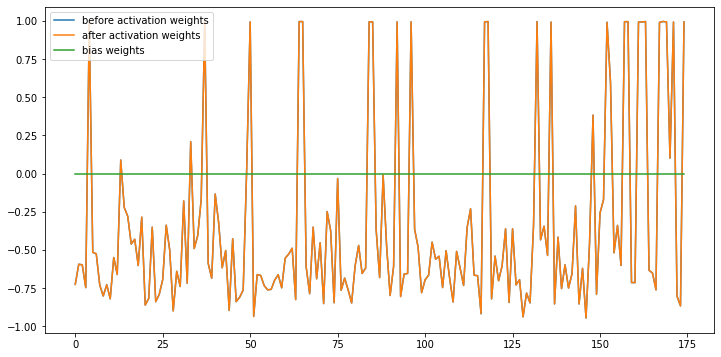

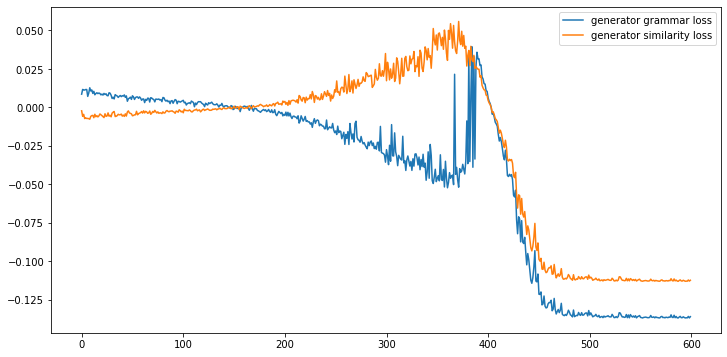

--------------------------------------------------
gold summary:
Bishop John Folda, of North Dakota, is taking time off after being diagnosed .
He contracted the infection through contaminated food in Italy .
Church members in Fargo, Grand Forks and Jamestown could have been exposed .
--------------------------------------------------
sam_wgan summary:
the Health churches North Dakota Immunization Program is feel time off through attending fever, nausea and Fargo Catholic Diocese (pictured) is where bishop 
--------------------------------------------------


method  comp ratio     intro      body   ending       var     total  \
0  SAM+WGAN    0.142987  0.411311  0.334314  0.45329  0.002427  0.368435   

    grammar        R1        R2        RL  
0  0.998324  0.385965  0.072727  0.245614

In [103]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

num = 0

org_text_1,org_text_2,org_text_3 = clear_article(sentences_dataset[num])
g_summ = gold_summary[num]

df1,_ = sam_wgan(g_summ,[org_text_1,org_text_2,org_text_3],display= True)
#df2,_ = bert_lexrank_sum(g_summ,[org_text_1,org_text_2,org_text_3])
#df3,_ = besm(g_summ,[org_text_1,org_text_2,org_text_3])
#df4,_ = besm_bert(g_summ,[org_text_1,org_text_2,org_text_3])
#df5,_ = abstract_method_1(g_summ,[org_text_1,org_text_2,org_text_3])
#df6,_ = abstract_method_2(g_summ,[org_text_1,org_text_2,org_text_3])
#result = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)
#result = pd.concat([df1, df2, df3, df5, df6], ignore_index=True)
df1


In [110]:
import sys

def get_features(dct1):
    return [dct1['comp ratio'][0],dct1['intro'][0],dct1['body'][0],dct1['ending'][0],dct1['var'][0],dct1['total'][0],dct1['grammar'][0],dct1['R1'][0],dct1['R2'][0],dct1['RL'][0]]

test_result = {}
test_result['SAM+WGAN']=[]
test_result['BERT+LexRank']=[]
test_result['BESM']=[]
test_result['BESM+kobert']=[]
test_result['Transformer']=[]
test_result['T5']=[]

In [111]:
def get_test_statistics(test_result):
    df_data = {}
    df_data['method'] = []
    df_data['comp rate'] = []
    df_data['intro'] = []
    df_data['body'] = []
    df_data['conclusion'] = []
    df_data['isthmus'] = []
    df_data['simlirality'] = []
    df_data['grammarity'] = []
    df_data['R1'] = []
    df_data['R2'] = []
    df_data['RL'] = []
    for key in test_result:
        df_data['method'].append(key)
        data = np.asarray(test_result[key])
        df_data['comp rate'].append(np.mean(data[:,0]))
        df_data['intro'].append(np.mean(data[:,1]))
        df_data['body'].append(np.mean(data[:,2]))
        df_data['conclusion'].append(np.mean(data[:,3]))
        df_data['isthmus'].append(np.mean(data[:,4]))
        df_data['simlirality'].append(np.mean(data[:,5]))
        df_data['grammarity'].append(np.mean(data[:,6]))
        df_data['R1'].append(np.mean(data[:,7]))
        df_data['R2'].append(np.mean(data[:,8]))
        df_data['RL'].append(np.mean(data[:,9]))

    df = pd.DataFrame(df_data)
    return df

In [120]:
def prepare_data(offset,length):
    document = []
    for i,doc in zip(range(offset,offset+length),sentences_dataset[offset:offset+length]):
        intro,body,end = clear_article(doc)
        document.append([gold_summary[i],intro,body,end])

    return document


document = prepare_data(50,50)


In [52]:
document[5]

['Prime Minister and his family are enjoying an Easter break in Lanzarote .\nSported the same £20.99 beige loafers as he wore in Portugal last year .\nPM sat and had a drink at a beach-side cafe on the Spanish Island .',
 'Hes been accused of making many a fashion faux pas while on holiday. But the Prime Minister seems to be deaf to his critics. Yesterday David Cameron was seen in the same pair of beige loafers he wore on holiday last year. Mr Cameron, who is in Lanzarote with his family, got\xa0 the £20. 99 shoes from high street store Aldo and took them with him to Portugal last summer.',
 'Retread: David Cameron with Samantha yesterday. And yes - hes wearing the same shoes. David Cameron and Samantha in Portugal last year - where he debuted his beige loafers. Yesterday he teamed them with a casual. navy blue shirt and beige shorts on a trip to Teguise in the centre of. ever fashion consultant Mrs Cameron trumped her husband in the style. stakes, wearing an elegant black maxi dress a

1 / 50
------------------------------------------------------------------
Fears are growing that Britains jails are becoming a hotbed of extremism after it was revealed today that nearly half the inmates of one top security prison are Muslim. Some 42 per cent of those housed at Category A Whitemoor jail - and more than a quarter of those in London prisons - consider themselves to be of Islamic faith. Experts now fear large numbers are being radicalised on the inside, where they say the spread of Jihadist ideas is rife. Figures show more than a quarter of inmates in London jails are Muslim, with one Category A jail revealing 42 per cent of its convicts follow the Islamic faith. Whitemoor inmate Zia Al Haq, left, was jailed for 18 for planning bomb attacks in London while Nezar Hindawi, right, was handed a 45-year sentence for plotting to blow up a jet. A source at Cambridgeshire jail Whitemoor told the Sunday People: Whitemoor is now effectively run by Muslims, many of whom are Jihadis.

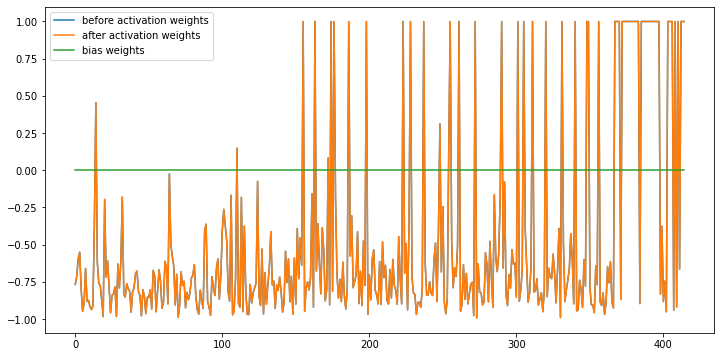

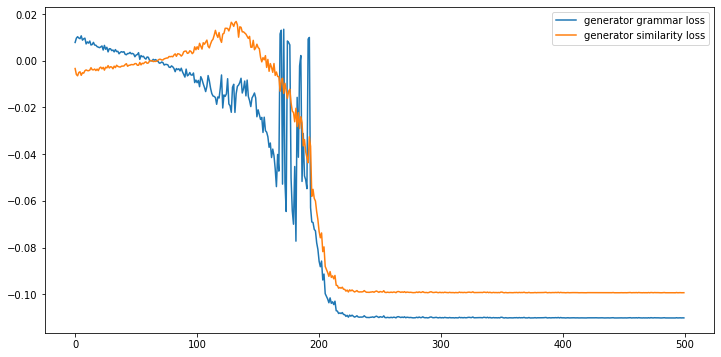

--------------------------------------------------
gold summary:
Increasing Muslim prison population highlighted by Whitemoor jail .
More than one in four of its convicts say they are of Islamic faith .
Fears the trend is down to growing radicalisation by Jihaists .
Shadow Justice Secretary Sadiq Khan calls for government action .
--------------------------------------------------
sam_wgan summary:
now are Taliban ground to doing risks needs is at inside Muslim an record risks to too Zia 18 to bomb Justice A Prison Service spokesman last night: Prisoners are held in establishments most suited to managing their needs and level of risk. The most recent independent inspection of HMP Whitemoor safe environment and praised for professionalism dedicated care. 
--------------------------------------------------
bert_lexrank summary:
The most recent independent inspection of HMP Whitemoor found it to be a safe environment and praised staff for their professionalism and dedicated care.The Gover

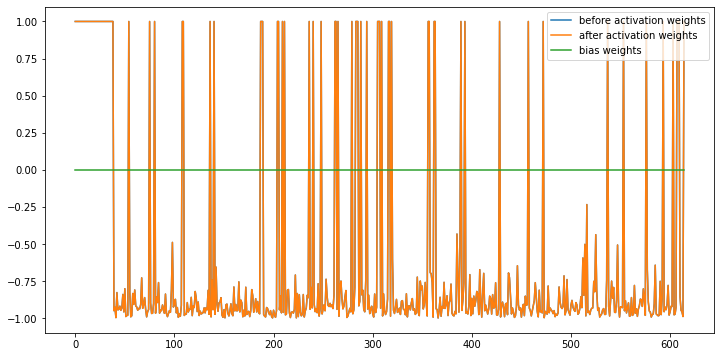

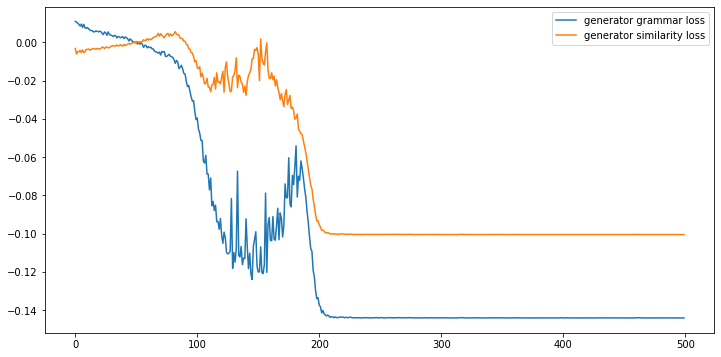

--------------------------------------------------
gold summary:
NEW: Palestinian security forces say they will investigate the allegations .
The Human Rights Watch report focuses on seven incidents in the West Bank and two in Gaza .
Journalists were "tortured, beat, and arbitrarily detained," the report says .
The rift between Fatah and Hamas is behind most of the incidents, it says .
--------------------------------------------------
sam_wgan summary:
 (CNN) -- Palestinian journalists are finding reporting increasingly difficult in the face of the growing abuse toward them by Palestinian security forces in the West Bank and Gaza, according to a report released Wednesday by Human Rights Watch. Palestinian press territories. detained journalists, and says readiness to investigate he said, consult and violate human journalists. of all Most controls Palestinian Authority, and controls Pro-Hamas West Bank and journalists in Gaza. report suggests that We dont detain background. States and 

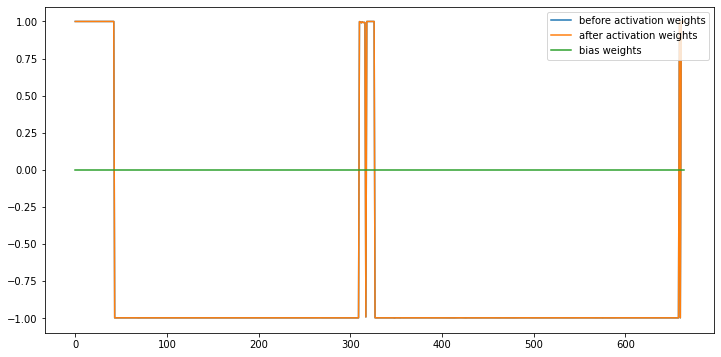

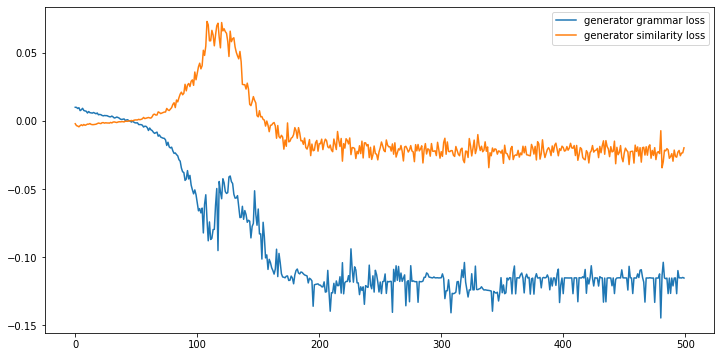

--------------------------------------------------
gold summary:
NEW: Next terror attack on U.S. likely to originate in Pakistan tribal areas, report says .
Terrorists with biological weapons could kill millions, panel's chairman says .
Biological attack more likely than nuclear attack, report says .
Number of nations with nuclear weapons also growing, panel says .
--------------------------------------------------
sam_wgan summary:
 WASHINGTON (CNN) -- Terrorists are likely to use a weapon of mass destruction somewhere in the world in the next five years, a blue-ribbon panel assembled by Congress has concluded. Police watch over travelers at New Yorks Grand Central Terminal before Thanksgiving. to biological one could the and have much weapons ahead Graham said more because would Biological weapons more he Anthrax is a natural product of dead animals. Other serious pathogens are available in equally accessible forms. There convert he organizations on acquiring Sen. of pathogens materi

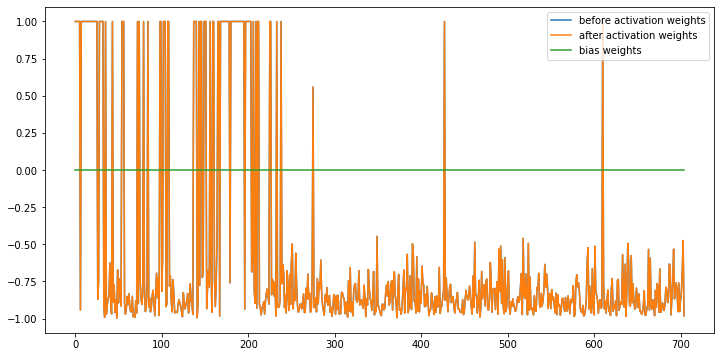

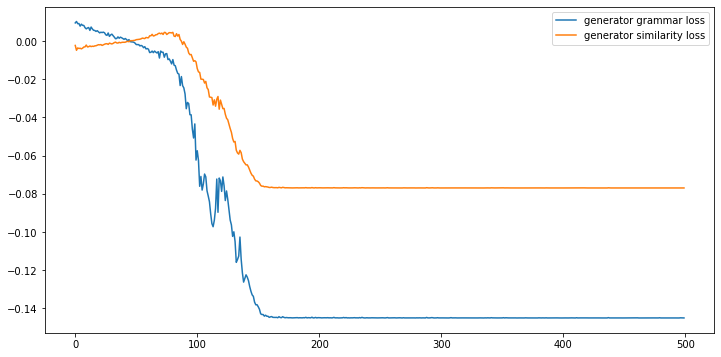

--------------------------------------------------
gold summary:
Efren Peñaflorida was bullied by gangs in high school in the Philippines .
Now his Dynamic Teen Company offers an alternative to gangs through education .
Since 1997, some 10,000 members have taught more than 1,500 children in slums .
Vote now for the CNN Hero of the Year at CNN.com/Heroes .
--------------------------------------------------
sam_wgan summary:
 CAVITE CITY, Philippines (CNN) -- 16, Rhandolf Fajardo reflects on his former life as a gang member. Efren Peñafloridas Dynamic Teen Company offers Filipino alternative to gangs through education. mates life, sixth grade. In past years, Foundation, charity. never improve, I would probably jail right an alternative to gang education. now for Hero of the groomed slums as old, says They are all victims of poverty. For the past 12 years, and his team of teen volunteers have taught basic reading and writing to children living on streets. Their main tool: A pushcart class

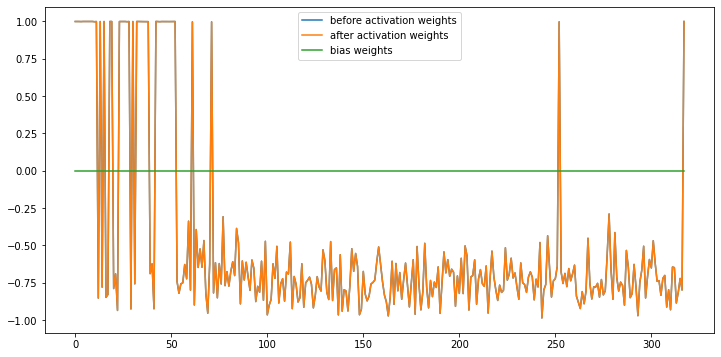

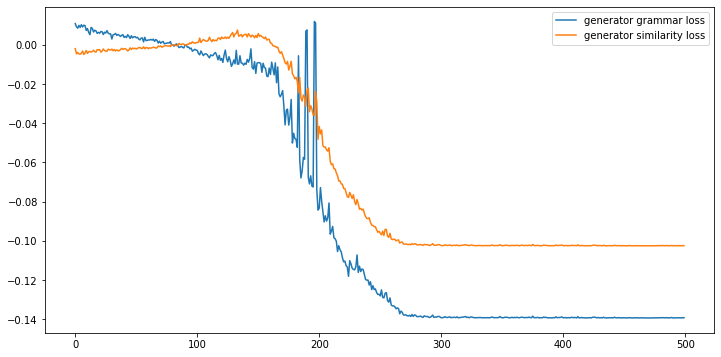

--------------------------------------------------
gold summary:
The free iPhone app comes with a 'missile strike' and a 'car crash'
--------------------------------------------------
sam_wgan summary:
 Last updated at 2:18 PM on 30th December 2011. Bored of surroundings want things up? that broken bit of office machinery? there’s app that’ll add a bit of action your life by super-imposing dramatic special effects over mobile phone footage. J. Star use 
--------------------------------------------------
bert_lexrank summary:
Looks like I’m leaving early today.Last updated at 2:18 PM on 30th December 2011.Kaboom: A MailOnline reporter finds himself in the line of fire.Bored of your surroundings and want to liven things up?Or fancy destroying that broken bit of office machinery?
--------------------------------------------------
besm summary:
Last updated at 2:18 PM on 30th December 2011. Swirls of dust precede an SUV dropping out of the sky and flying into the camera. There are even act

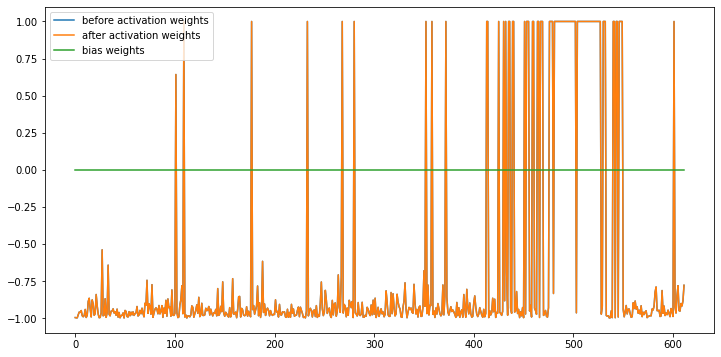

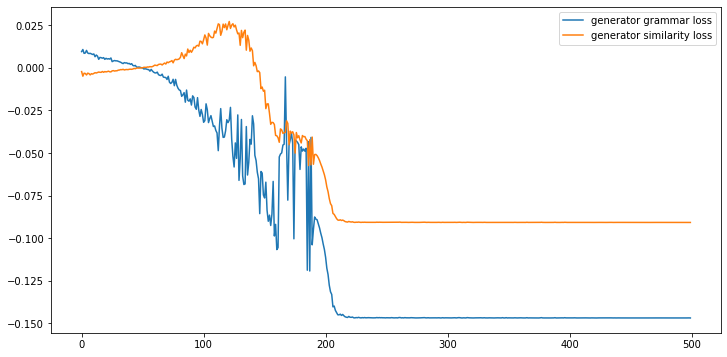

--------------------------------------------------
gold summary:
Lee Rowlands tried to raise £2,000 a day for charity to win the competition .
But the strain got too much and he suffered a psychotic episode .
He stabbed fiancée Madelaine Moir in the breast, arm, fingers and knee .
--------------------------------------------------
sam_wgan summary:
attacked has run ‘We want also the two ’ Miss finger she recognise who attacked ‘He wasn’t want hurt her and rationally,’ said Moir wrote her victim statement: I can’t say what It is as if somebody else had taken over his body. ’ The court heard she had helped turn Rowlands’ life around. had served time in jail, and they entered the wedding contest because he was desperate to prove himself. Richard Barradell, defending, said the couple raise £2,000 each However, it clear ‘things getting to Lee Rowlands’. Sorry
--------------------------------------------------
bert_lexrank summary:
This is why I can’t say what happened.It is as if somebody e

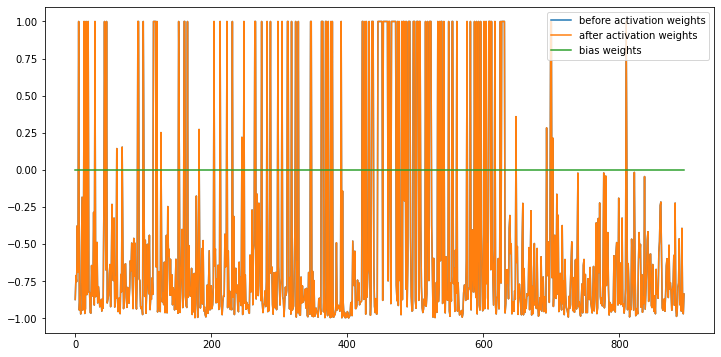

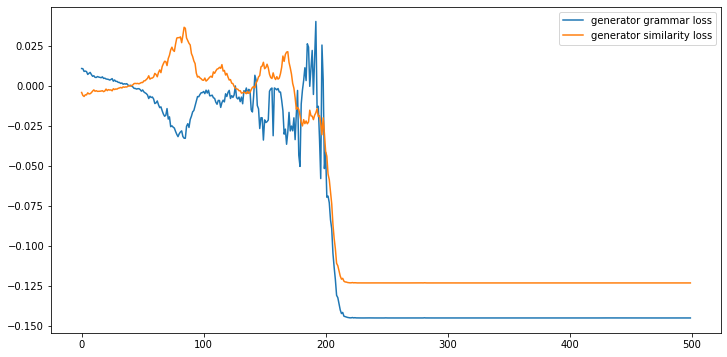

--------------------------------------------------
gold summary:
First officer didn't completely load radio frequency, NTSB says .
He and pilot then were distracted by discussion, personal computers, NTSB says .
NTSB also blames air traffic controllers for not realizing problem earlier .
--------------------------------------------------
sam_wgan summary:
pilots asleep overflew by Safety pilots by 37,000 feet, also the most complete official to notify FAA loses aircraft. co-pilot, read the frequency contact last frequency megahertz, 17) first completed an attempt to The likely captain distracted the controller, the NTSB captains absence prevented the actions. new that they chatter did radio The laptop computers of numerous visual alerts, including text messages by airline dispatchers and at least nine regarding their the airplanes primary flight display, the NTSB Airlines prohibited the the NTSB Both told the first indication when a flight to ask about arrival time. and [Minnesota] lef

Unexpected error: <class 'IndexError'>
8 / 50
------------------------------------------------------------------
Four police officers involved in the fatal pursuit of a young student used unnecessary, excessive and unlawful force against him, a court has heard. Brazilian student Roberto Curti, 21, died in the early hours of March 18, 2012, after a chase and violent struggle with police in Sydneys CBD in which he was tasered, handcuffed, hit with capsicum spray and knelt on. Policemen Scott James Edmondson and Daniel David Barling have been charged with assault occasioning actual bodily harm while Chin Aun Lim and Damian John Ralph face the charge of assault. All four have pleaded not guilty. Brazilian student Roberto Curti died in the early hours of March 18, 2012, following a chase and violent struggle with police in which he was Tasered, handcuffed, hit with capsicum spray and knelt on. A court heard on Monday that the four police officers involved used unnecessary, excessive and unl

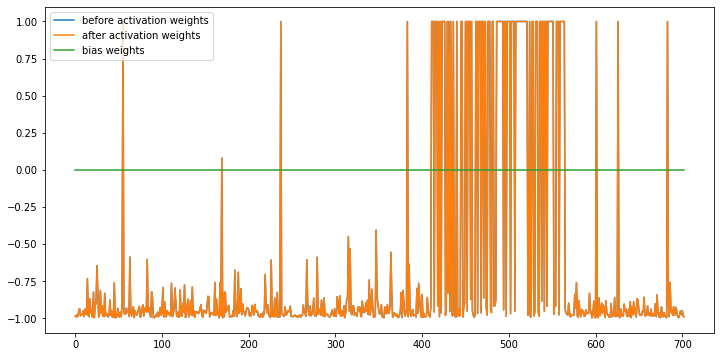

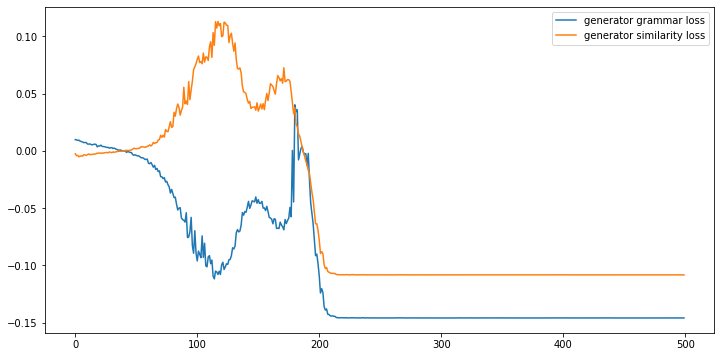

--------------------------------------------------
gold summary:
A court heard that four police officers used 'unnecessary, excessive and unlawful force' against a student .
Brazilian student Roberto Curtis died in March 2012 following a chase and violent struggle with police in which he was tasered .
All officers have pleaded not guilty .
A four week hearing commenced on Monday .
--------------------------------------------------
sam_wgan summary:
handcuffed, Policemen by Earlier this month four police officers seeking permanently criminal proceedings against them. hearing the week Barrister told they were application to the proceedings against All guilty and this month were to halt criminal proceedings Barrister Bret Walker the court, against the four police officer including Scott Edmondson was rooted an eradicable error The case against the four been tainted by directed interviews which took place in the days after Mr Curtis Walker the interviews, compelled to answer threat of acti

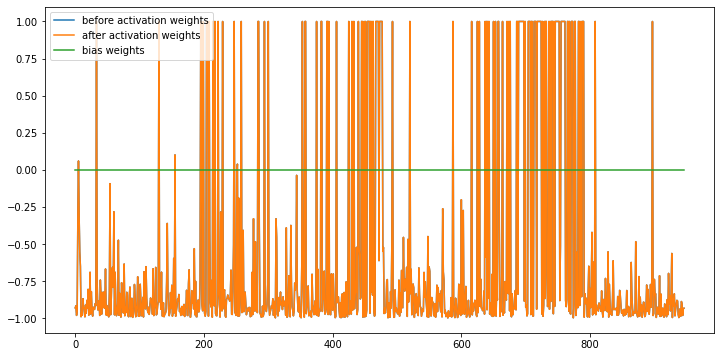

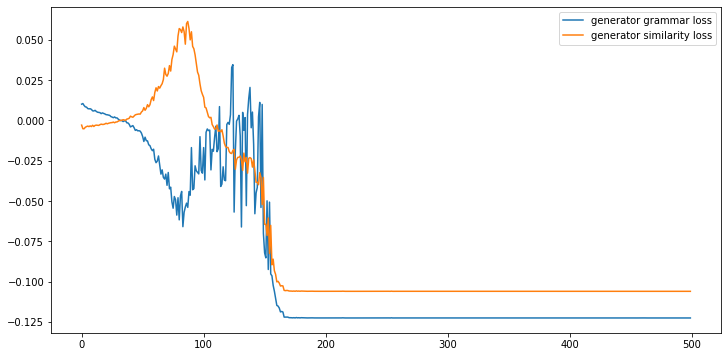

--------------------------------------------------
gold summary:
Patricia Glancy, 36, conned couples out of money at Wentworth Golf Club .
She admitted five counts of fraud, with the stolen money totaling £10,787 .
Glancy was today spared jail after proving how the spent stolen money .
She had donated large sums to charity and took dying friend to New York .
--------------------------------------------------
sam_wgan summary:
jail before she had every money and that golf of that scam. handed Thelma to golf club’s auctions cancer years of good money to New to cancer Money: all was you provide and had given charity for bought equipment from the shop at discount with some of the proceeds had taken from your customers. personally, five Wentworth had Wentworth near May last as events tasked wedding getting married with Glancy for On They left blank and she said she would stamp them with Wentworth completed her name and One payment by bank transfer - instead of giving the club’s details to c

Unexpected error: <class 'IndexError'>
10 / 50
------------------------------------------------------------------
The secret to staying slim could be in saliva. Researchers have found that a gene that makes a carb-busting compound has a large influence on weight. Nicknamed the Atkins Gene in some quarters after the popular diet, its official scientific nickname is AMY1. The gene makes an enzyme that is found in saliva and begins the breakdown and digestion of starchy foods like chips, crisps and rice. Carbohydrates: Researchers have found that a gene that makes an enzyme found in saliva begins the breakdown of starchy food and can have a large influence on weight. The study showed that people who had more copies of the gene made more of the enzyme and were more likely to be slim. Although we normally think of genes as coming in pairs, some people will only have one copy of a gene.   Others will have two, three or even more. In the case of the AMY1 gene, it possible to have up to 20 cop

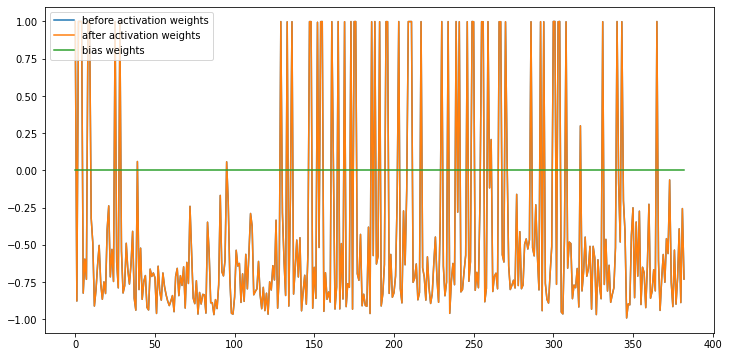

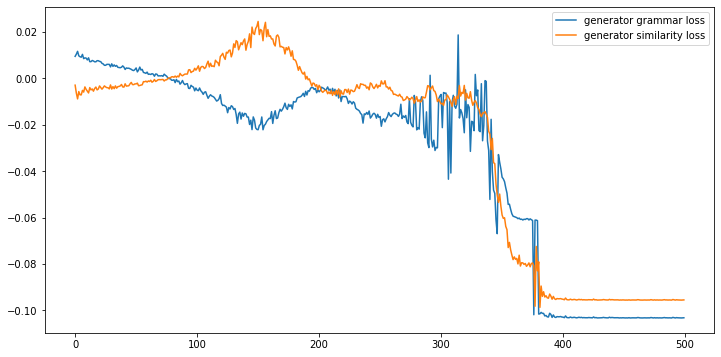

--------------------------------------------------
gold summary:
AMY1 gene makes a carb-busting compound and can influence weight .
Gene makes enzyme in saliva that begins the breakdown of starchy food .
It has been nicknamed the Atkins Gene after the popular diet .
Study finds that those with more copies of the gene are likely to be slim .
--------------------------------------------------
sam_wgan summary:
 secret to staying in saliva. on the pairs, only copy even more. of AMY1 gene, to who would find more difficult weight journal reports. gene has the Robert Atkins (pictured)   gut obesity metabolism. researchers, and London, said may have tailored Tim Spector, joint more digestive and useful marker target for obesity. the overweight people. food
--------------------------------------------------
bert_lexrank summary:
Others will have two, three or even more.The secret to staying slim could be in saliva.In the case of the AMY1 gene, it possible to have up to 20 copies.Although we no

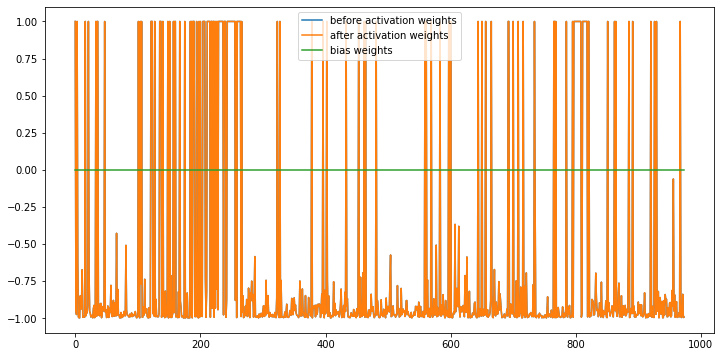

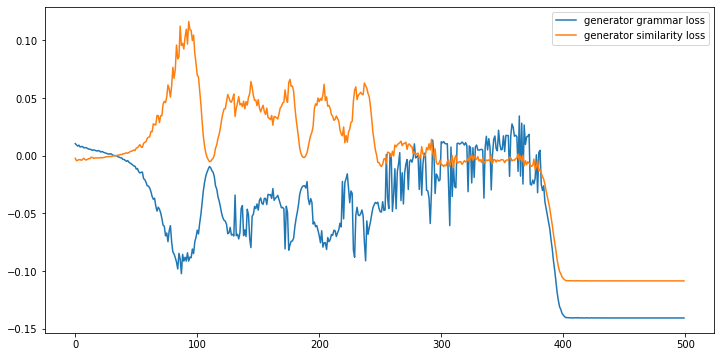

--------------------------------------------------
gold summary:
Historians seeking to identify troop of fallen WWI soldiers found in France .
Eric Saunders provided DNA sample to see if one was his great uncle .
Private Frederick Thompson was reported missing in action at the age of 20 .
--------------------------------------------------
sam_wgan summary:
 to step 99 in in 1914. during Saunders, Worcester, submitted remains and proves his sample in the will of in great Private Frederick wife) age of 15 found in Beaucamps-Ligny, And Commonwealth Grave after the DNA testing they will finally be able discover their and give a funeral years The remains of the soldiers were uncovered by digging up sewers Private Frederick Thompson, killed in action early in the First World War, may identified a century after his death. Archaeologists partial century from the relatives I have know it hits anything seven - two or In the - Cemetery - for these unknown several but to funeral York and Regiment 

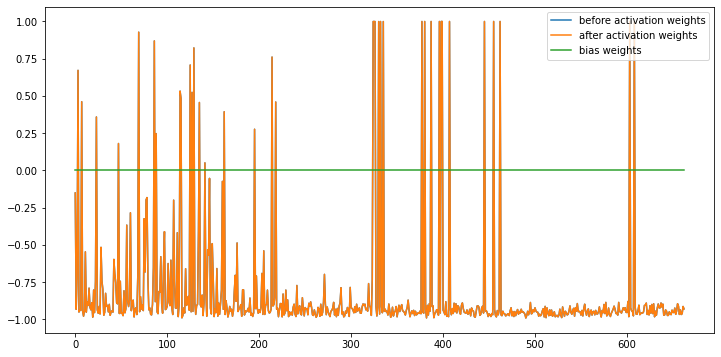

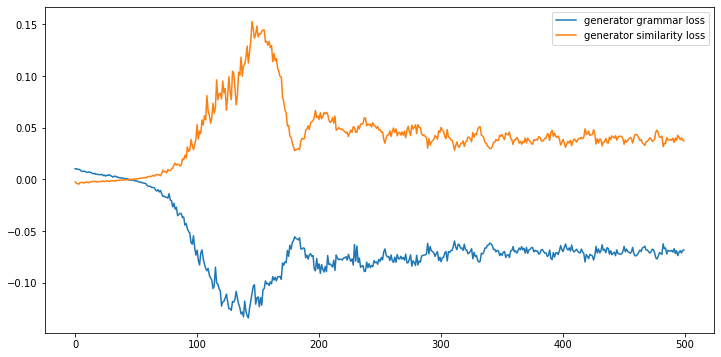

--------------------------------------------------
gold summary:
David Lee Collins, 18, was stabbed to death after a fight broke out .
Died after being stabbed in Ayia Napa nightclub last November .
Mohammed Abdulkadir Osman, 20, .
originally from Somalia was jailed .
Court: Collins' friends - who were all soldiers - started the fights .
--------------------------------------------------
sam_wgan summary:
 British teenager to prison death during nightclub brawl Collins, 18, from stabbed a nightclub in resort Ayia The that originally provoked and out a switchblade and fatally Lee Collins, was death after a out in the of last November photo right is image his The bench confronted Osman punched by unidentified nightclub patron, clenched fist and bad men? a a challenge a it was soldiers that also into was Osmans he didnt with had from arrived But factor Police room. at the time two knuckles switchblades. 2nd Regiment heart post-mortem. while off-duty: second Scene: soldiers nightclub. inde

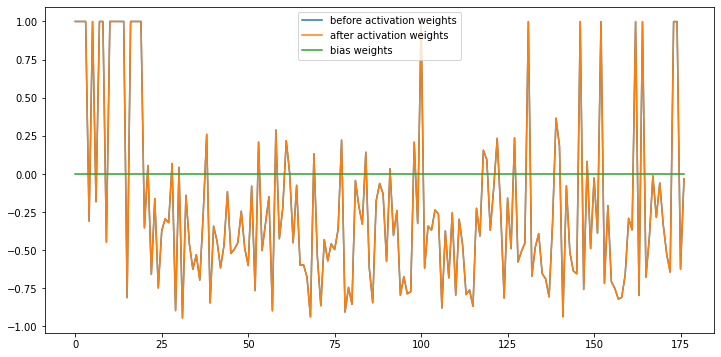

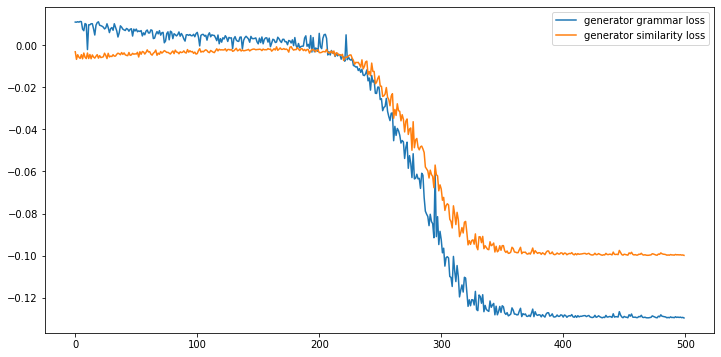

--------------------------------------------------
gold summary:
The Virgin Group was founded by Richard Branson in 1970 .
Student Magazine, started by Branson at 16, was forerunner to the group .
Today Virgin has more than 200 companies in a range of industries .
--------------------------------------------------
sam_wgan summary:
 (CNN) -- Virgin, leading venture capital is one of the worlds recognized and respected brands. leisure, ($20 billion Virgin studios was $1 billion
--------------------------------------------------
bert_lexrank summary:
The first recording was the 1973 smash Tubular Bells, by Mike Oldfield.Conceived in 1970 by Richard Branson, the company started out with a magazine four years before that, which Branson began while still at school.The next move was into the music industry, setting up Virgin as a music retailer and then branching out into music production.(CNN) -- Virgin, a leading branded venture capital organization, is one of the worlds most recognized an

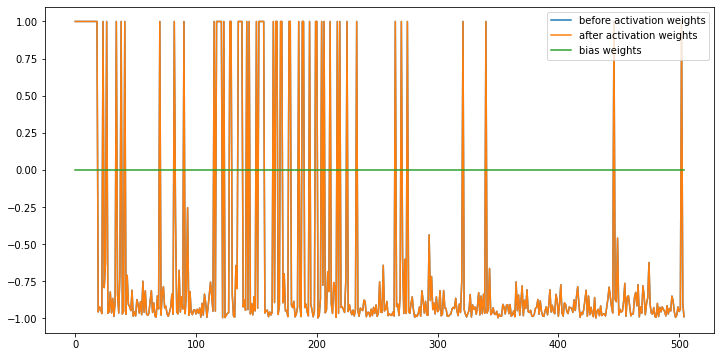

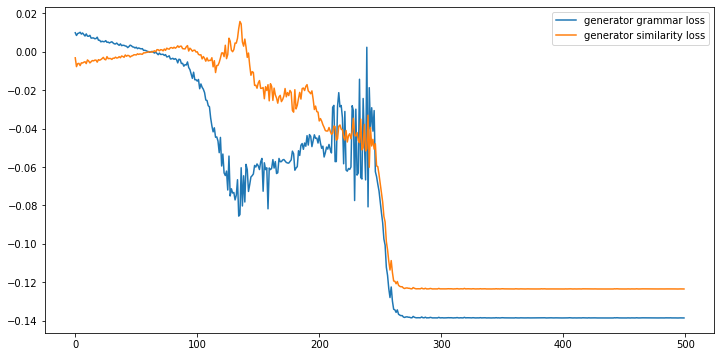

--------------------------------------------------
gold summary:
Called Megasphaera, the fossils were found in rock in southern China .
They are 60 million years older than date skeletal animals appeared .
But the cells are too complex to be belong to bacteria, the study claims .
They may represent shift between single-cell life and multicellular animals .
--------------------------------------------------
sam_wgan summary:
 Spherical fossils in China dating back 600 million years could be the remains of the planets earliest animals. million than huge new Earth fossils of 60 Called the ancient fossils come from rock called the longstanding interpretations of multicellular and from marine at the time. This opens shine light on and evolutionary multicellular organisms dominate in a Shuhai geobiology in College Science. fossils in China contradict Cambrian organisms individual colonies. Cambrian-Ordovician algae, including living
--------------------------------------------------
bert_lex

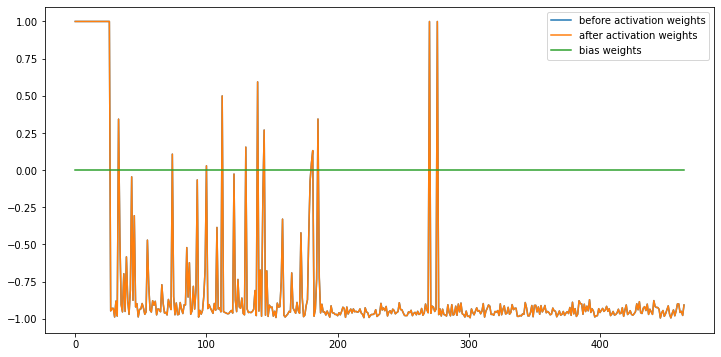

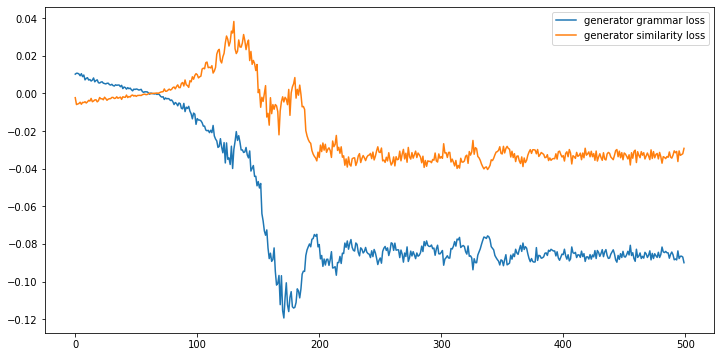

--------------------------------------------------
gold summary:
They even sprayed paint on his Ford Fiesta in calamitous giveaway .
--------------------------------------------------
sam_wgan summary:
 A motorist was stunned when he discovered double yellow lines had been painted underneath his car while it was parked - and then given a ticket. sprayed on of McCrystals the lines painted The 49-year-old to where Ford which a after council under the he 2pm painted housing a ones the so McCrystal parked in break saw below And, McCrystal discovered he had a parking ticket. and fine.
--------------------------------------------------
bert_lexrank summary:
Nothing gave me the impression I couldnt.The 49-year-old had parked his Ford Fiesta in the street near to a Co-operative store and a petrol station, where he works, for three years.There were no lines there when I parked.It appears that there was a communication breakdown between our contractors undertaking the lining work and our enforce

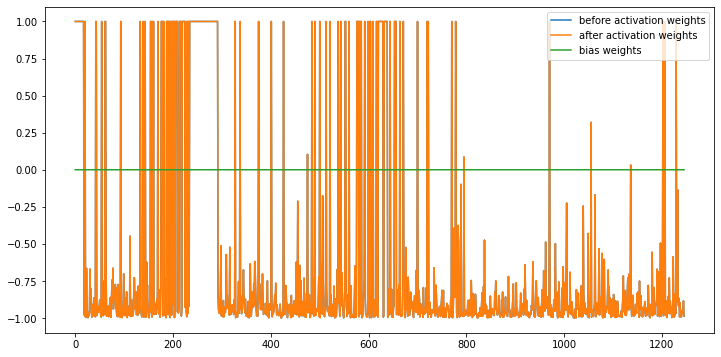

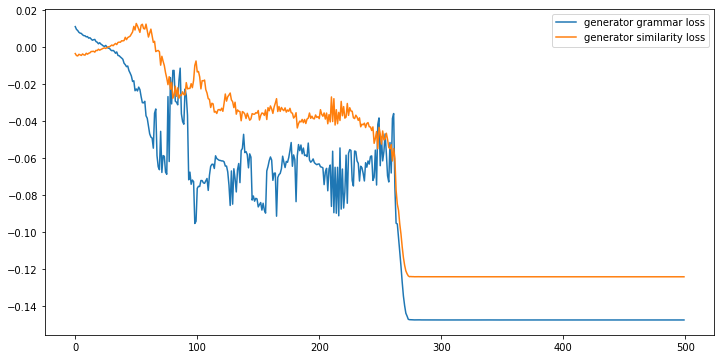

--------------------------------------------------
gold summary:
East Coast, First Hull Trains, Grand Central and Great Northern lines hit .
Planned works in Holloway area of London were not completed in time .
Customers advised to  start and finish journey at Finsbury Park instead .
Thousands expected to make post-Christmas return journey on Saturday .
East Coast Trains apologised for cancellation on a 'very busy travel day'
National Rail said  services would be 'significantly disrupted' tomorrow .
--------------------------------------------------
sam_wgan summary:
 One of the country’s biggest rail terminals will be ‘effectively closed’ today because of over-running engineering works. be The disruption year, return home the Trains website it said that timetable currently soon they need to finish in north London, at least one train of the overrun in Holloway A reduced service to station will go ahead on Sunday, with trains leaving up 20 normal Kings Last night Passenger Focus, the in

Unexpected error: <class 'IndexError'>
17 / 50
------------------------------------------------------------------
Veteran actor Victor Spinetti, who starred in all three Beatles films, has died at the age of 82. The Welsh star, who also appeared in a string of acclaimed movies as well as taking roles in the West End and on Broadway, died after a fight with pancreatic cancer. Close friend Barbara Windsor, on whose Radio 2 show he made a recent appearance, was one of his final visitors before his death this morning at a hospice in Monmouth. Respected: Victor Spinetti was told by the late George Harrison he had to star in all the Beatles films, pictured here in 1972. Tributes: Actor Victor Spinetti, pictured left in 2010, died today at a hospice - one of his last visitors was close friend Barbara Windsor, pictured right with the actor in the 1960s. Spinetti’s agent, Barry Burnett, said: He had cancer for a year, but he was very cheerful to the end. I spoke to him on Friday and he was talk

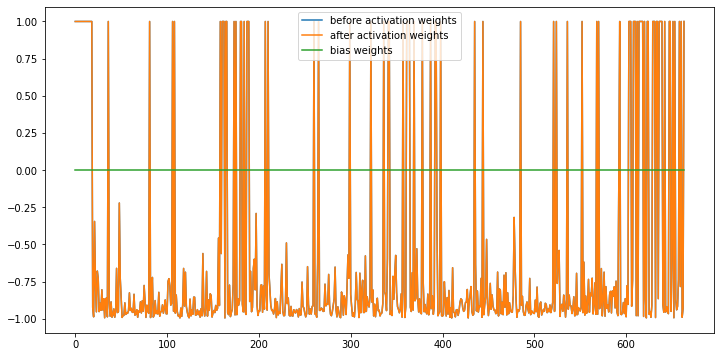

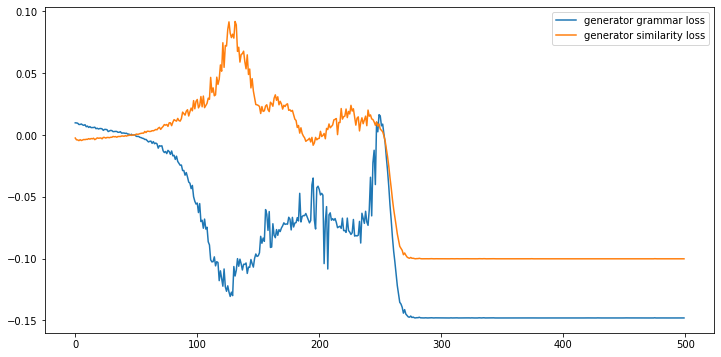

--------------------------------------------------
gold summary:
Sprang to prominence in three Beatles films of the 1960s: Hard Day’s Night, Help! and Magical Mystery Tour .
Close friend Barbara Windsor was one of the last people to visit the veteran actor .
His agent Barry Burnett, said: 'He was very cheerful to the end'
--------------------------------------------------
sam_wgan summary:
 Veteran actor Victor Spinetti, who starred in all three Beatles films, has died at the age of 82. in Victor Spinetti, left on and he was about his able easily serious classical comedy roles in sitcoms. in Cake films Night, 2, Wild working waiter and Hard and Magical Mystery Tour. once in them, and see you. Pink Spinetti won in play, The as 60-year Spinetti Superstar Wife, and the Actor’s Life For Spinetti wrote poetry, notably Watchers Along Mall, which have His memoirs, Victor Up Front, filled with anecdotes, including that in securing censor for Oh! a 
---------------------------------------------

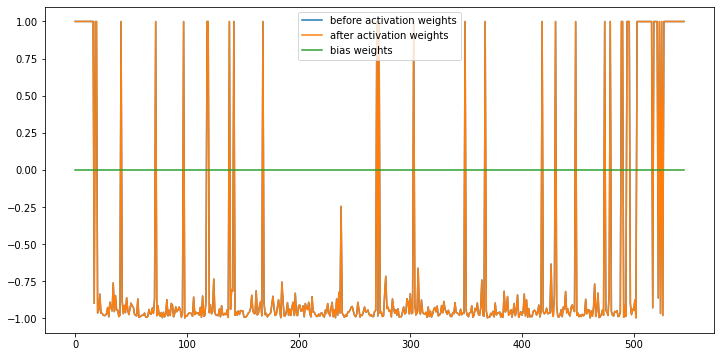

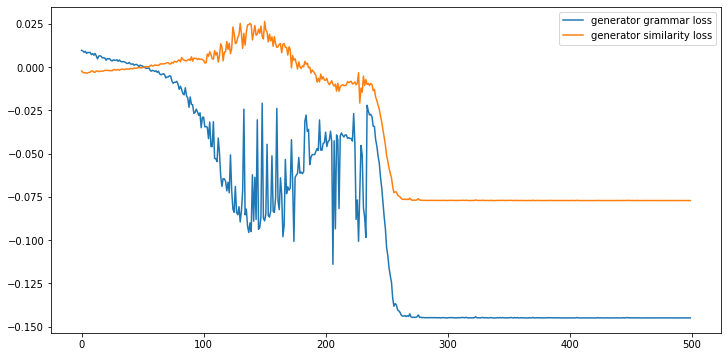

--------------------------------------------------
gold summary:
Prime Minister took part in Great Brook Run for the third time .
Participating for first time in Oxfordshire run since becoming PM in 2010 .
Russian President Putin is renowned for his macho exploits .
Putin has been pictured competing in judo and holding a rifle while topless .
--------------------------------------------------
sam_wgan summary:
 Vladimir Putin enjoys posing bare-chested on horseback and with hunting rifles to  perpetuate his macho image. Britain, however, got the David a low medal race. stream charity and 109 he presented Mr race, invited race long, Laid-back: He most powerful man sported casual lycra and a pair of shorts nonetheless. Tired out: The Prime Minister with a fellow competitor reaching finishing Ice cold: Russias Prime Minister Vladimir Putin swims in a cold lake during a vacation in southern Siberia. 
--------------------------------------------------
bert_lexrank summary:
children normally

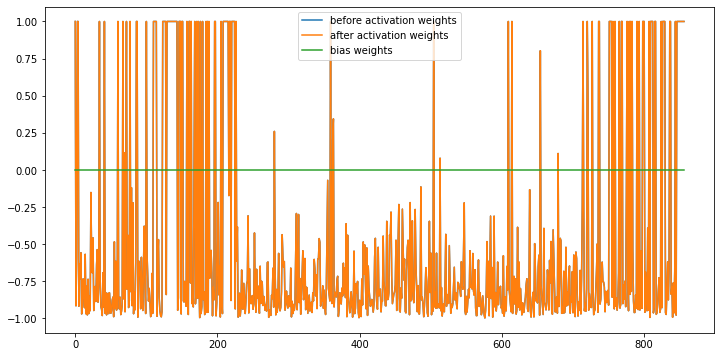

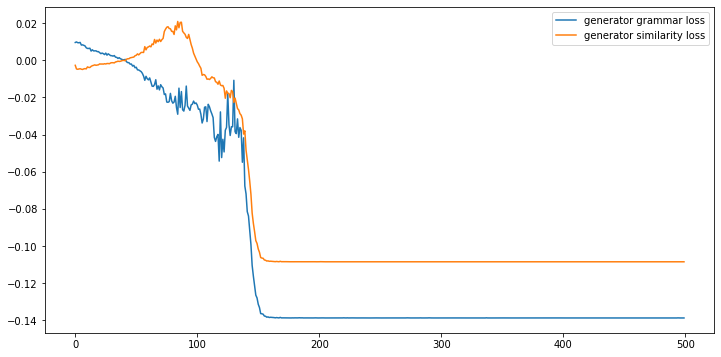

--------------------------------------------------
gold summary:
Ghana is a country rich in history, culture and natural beauty .
Mole National Park is home to more than 93 species of mammal .
Elmina Castle is the oldest remaining slave castle in Africa .
Osu, in Accra, offers visitors a vibrant nightlife .
--------------------------------------------------
sam_wgan summary:
 Upon arrival will African that Rich natural introduction to the circuit, for everyone in Ghana, ranging to bustling markets, tranquil beaches vibrant nightlife. There are 15 national parks and reserves across the country. A must see National Park, in central region. stunning and rare and hanging as Canopy for hearted, at forest level, nets and with vantage point of the beautiful surroundings. Another great to visit Ghanas largest wildlife refuge, Mole Park. castle crafts list cold to second-biggest bustling and stalls, a wide variety of such wooden fabric, jewelry and to Cultural the Palace the lake area is peacef

Unexpected error: <class 'IndexError'>
20 / 50
------------------------------------------------------------------
(CNN) -- Two separate incidents at coal mines in Southwest China over the weekend left at least three miners dead and 42 trapped, state media reported. Days of heavy rain caused a mine at Niupeng in Guizhou province to flood on Saturday morning; while rain-saturated earth on the surface collapsed into a shaft at another pit in Guangxi around noon the same day, killing three miners, Xinhua said. The report added that more than 1,000 police, firemen, and paramilitary personnel joined the mission to rescue the trapped workers at Niupeng. By Monday the water level at the mine had dropped but was still 40 meters (131ft) higher than where 23 of the miners are believed trapped, according to reports from China National Radio. Local authorities said the heavy rain may have caused a previously dry river to rise, while possibly increasing the water level in underground rivers around t

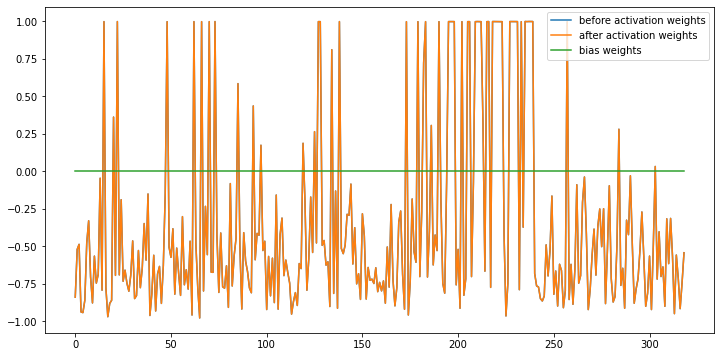

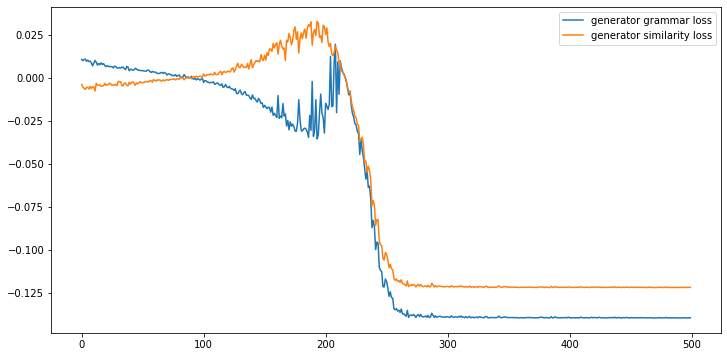

--------------------------------------------------
gold summary:
42 miners remain trapped in the two coal mines in southwestern China .
Days of heavy rain caused a mine at Niupeng in Guizhou province to flood .
"Rain-saturated earth on the surface collapsed into a shaft" at another pit in Guangxi .
--------------------------------------------------
sam_wgan summary:
left 42 the same miners, report more the heavy rise, from another trapped (1,200ft), other miners were reported the rain on complicated the rescue effort, The rescue is only equipped with shovels and Meng Qingguan, head of the Work Bureau, told CCTV on Saturday. regulations.
--------------------------------------------------
bert_lexrank summary:
Michele Philips contributed to this report.Continued rain on Sunday further complicated the rescue effort, it added.According to Xinhua, the Niupeng mines investors have already been detained by the police.50 other miners were reported to have escaped the cave-in.However, the head 

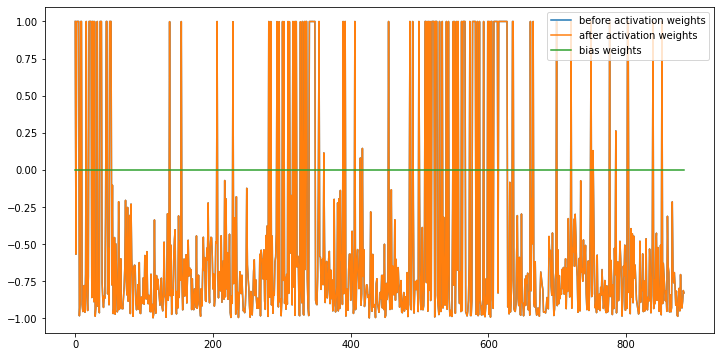

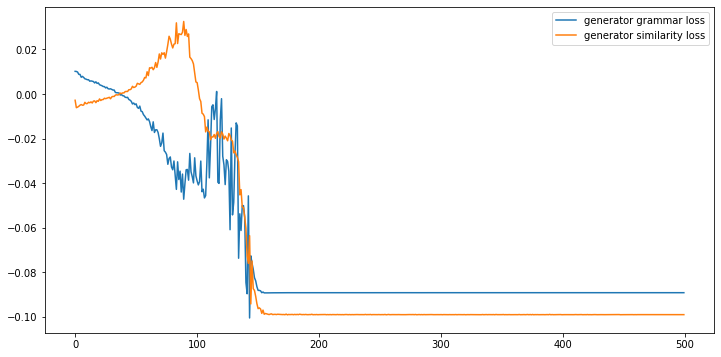

--------------------------------------------------
gold summary:
J'ade, designed by Italian company CRN, can store an eight-metre speedboat in its floating indoor garage .
Hydraulic-powered hatch fills with 18,000 litres of water and can also be used as an indoor ocean pool .
The luxury vessel was nominated for Best Interior at 2014 Monaco Yacht Show .
196-foot vessel also features a gym, hammam room, and aquarium, and can sleep ten guests in four cabins .
--------------------------------------------------
sam_wgan summary:
 the battle to be extravagant mega lot While helipads, waterslides, and theatres are additions of a stylish Italian the first floating drive-in garage. and without an Yacht Honey, The yacht speed vessels lower is being also used an internal this Beauty: the Yacht Trophy International Boat Show and was nominated for Best Interior Show. suite, crew and luxury: a ocean guests pool. Spa: mega also a mosaic-tiled hammam room (pictured), guests can sit after sea. yacht fo

Unexpected error: <class 'IndexError'>
22 / 50
------------------------------------------------------------------
BERLIN, Germany (CNN) -- A German cruise liner said Tuesday it plans to fly its passengers over the Gulf of Aden, instead of sailing them through, out of fear of pirate attacks in the region. Navy image of pirates operating off coast of Somalia in October this year. Hapag-Lloyd Cruises said all 246 passengers and most of the crew aboard the MS Columbus, currently at the start of an around-the-world cruise, will disembark at an undisclosed port, then fly to Dubai to continue their journey. The company called the move a precautionary measure. Pirate attacks in the waters off Somalia have shot up this year, with pirates staging increasingly bolder attacks on ever-bigger targets. So far this year, pirates have attacked almost 100 vessels off Somalias coast and successfully hijacked nearly 40, according to the International Maritime Bureau. Freight and cargo ships, cruise liners

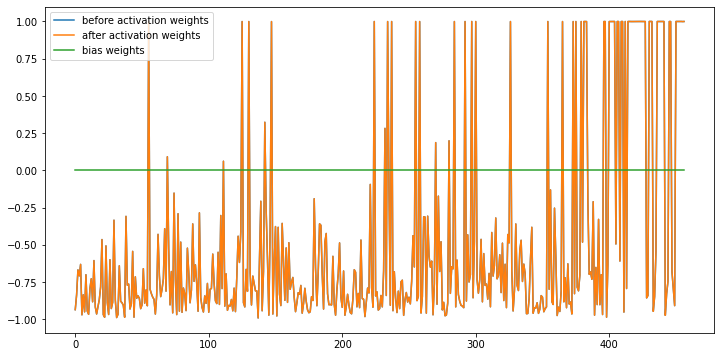

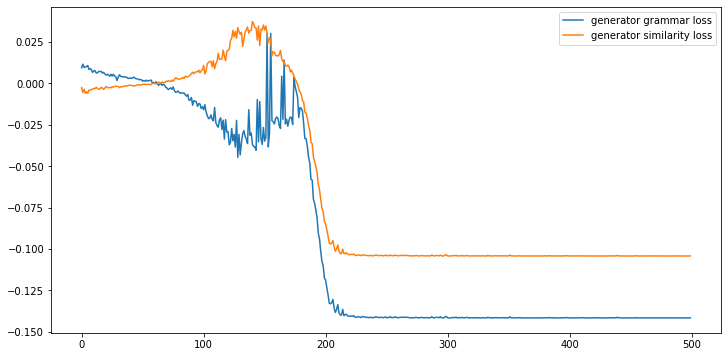

--------------------------------------------------
gold summary:
Passengers will fly to Dubai to continue their journey .
Hapag-Lloyd: Involves 246 passengers, most of crew aboard MS Columbus .
Prompted by travel warning for the area issued by German Foreign Ministry .
United States, UK advise those traveling near Somali coast to use extreme caution .
--------------------------------------------------
sam_wgan summary:
and off hijacked yachts how general for also had reached the leg world and The three them onboard, Both crew and passengers Office advise near the Somali coast to extreme caution of the pirate Last week, the Australian government issued a similar warning about travel to the region. also urged Australian a robust and layered protective security through the Frederik Pleitgen contributed to this report. 
--------------------------------------------------
bert_lexrank summary:
-- CNNs Frederik Pleitgen contributed to this report.Representatives of Hapag-Lloyd and the German 

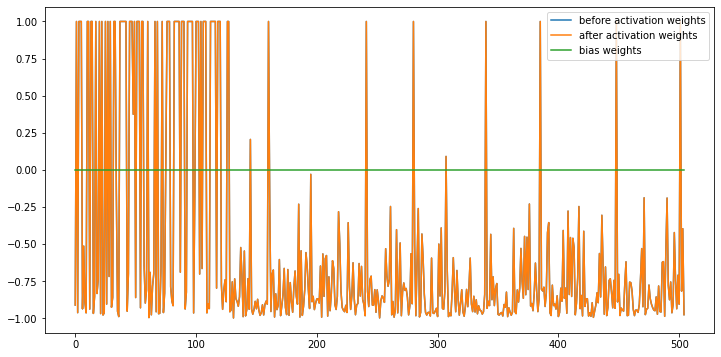

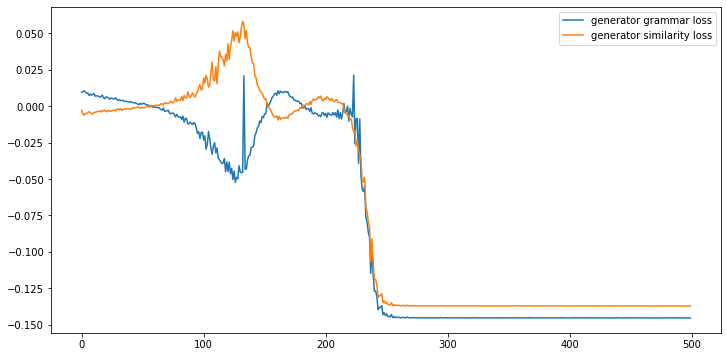

--------------------------------------------------
gold summary:
Manchester United host Newcastle in the Premier League on Boxing Day .
United boss Louis van Gaal has guided them to third in the Premier League so far, despite a catalogue of injuries at the club .
Ex-Old Trafford manager Sir Alex Ferguson thinks United can only get better when United's injury list improves under the Dutch coach .
--------------------------------------------------
sam_wgan summary:
Louis Gaal has welcomed support from Alex Ferguson it more on succeed Manchester The Trafford boss who has taken United to third the table despite catalogue injuries, saying: ‘When gets the you he’s great do Dutchman responded at conference by thanking Ferguson for vote of confidence, feels that it has put even more pressure get Manchester United boss has welcomed the public support Sir Alex Ferguson. Ferguson for Im doing like Premier Marouane Gaal. earlier
--------------------------------------------------
bert_lexrank summa

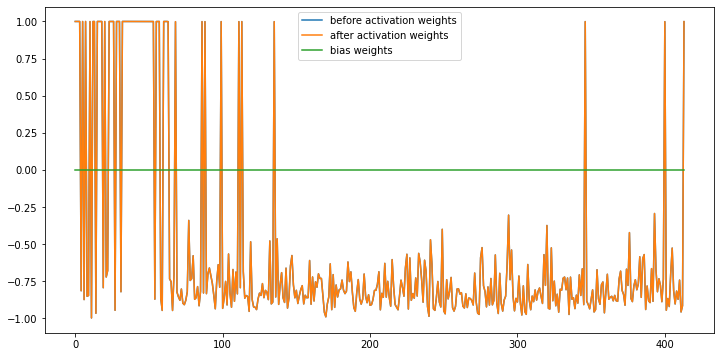

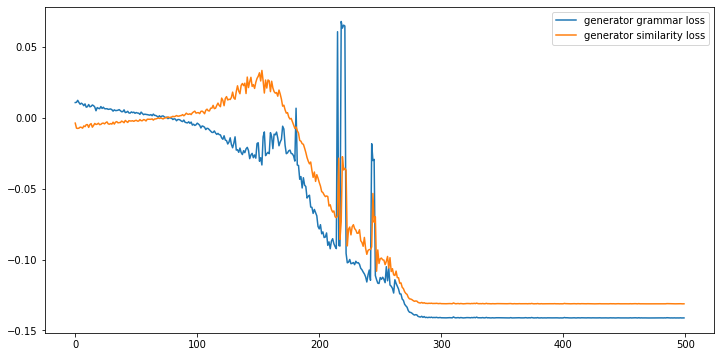

--------------------------------------------------
gold summary:
Controversial scientist created world's first cloned dog .
Remains found in Siberia last year to be used .
Research 'could begin this year'
--------------------------------------------------
sam_wgan summary:
 A woolly mammoth in in walk Earth again 10,000 years, after Russian signed with a controversial Korean to clone the Hwang Woo-Suk – who created the world’s first cloned dog, Snuppy, in 2005 – will implant the nucleus from a mammoth cell an elephant egg a mammoth embryo. The implanted (L) hands of clone mammoth. the mammoth usually 
--------------------------------------------------
bert_lexrank summary:
warming has thawed ground in eastern Russia that is usually almost.University for joint research next year aiming to.permanently frozen, leading to the discoveries of a number of frozen.Mammoths became extinct about 10,000 years ago.The embryo will then be implanted into an elephant’s womb.
--------------------------

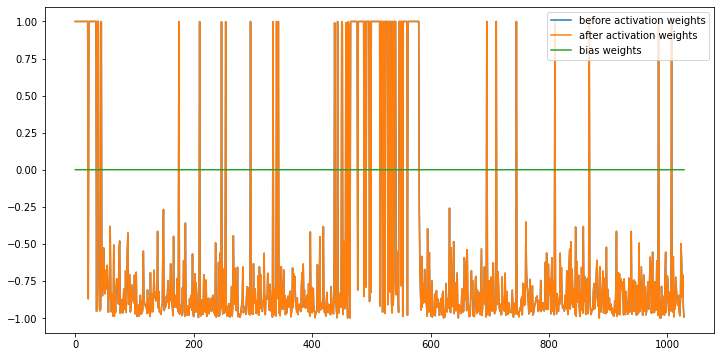

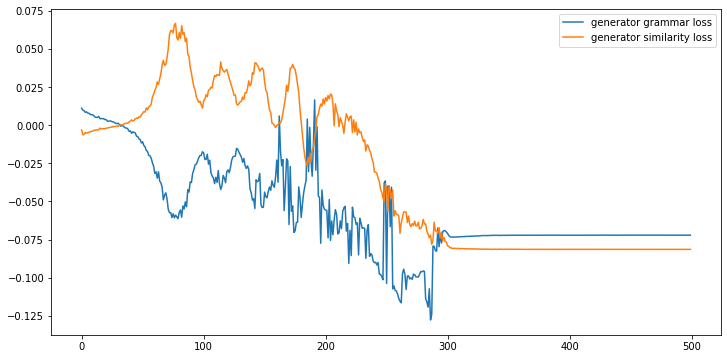

--------------------------------------------------
gold summary:
China's third city Guangzhou announces first steps in unbolting 'Re-education Through Labor' system .
System was set up in the 1950s under Mao Zedong and modeled on the Soviet 'gulags'
It provides for detention without trial for petty thieves and prostitutes to drug abusers .
Human Rights Watch says the changes to the system, however, are only cosmetic .
--------------------------------------------------
sam_wgan summary:
 Hong Kong (CNN) -- Chinas third-largest city Guangzhou -- capital of Chinas richest and most progressive province Guangdong -- has announced has taken the first concrete steps in unbolting the countrys often reviled Re-education Labor (RTL) system. the throughout camps without died of accused and drug been Yong stopped approval further of personal An administrative tribunal official Xiao Zhixiong added that with no new detention being heard, the system would eventually be digested out but specific refor

Unexpected error: <class 'IndexError'>
26 / 50
------------------------------------------------------------------
A dog which viciously attacked a four-year-old boy only to be scared off by a fearless cat has been euthanized, it has been claimed. Scrappy, an eight-month-old Labrador-Chow mix, was apparently put down at Bakersfield animal shelter after he was filmed attacking his young neighbor Jeremy Triantafilo. Jeremys life was saved when his pet cat Tara selflessly pounced on the dog as it launched its attack, chasing the vicious animal down the street so her best friend could receive emergency medical help. Lurking: Jeremy Triantafilo was outside his familys home when Scrappy the dog escaped and ran towards him. The Labrador-Chow mix has since been destroyed at nearby at Bakersfield animal shelter. To the rescue! Tara runs towards her owner as Scrappy shakes him. The dog was euthanized after continuing to show aggression during a 10-day assessment. Scrappy was destroyed after he co

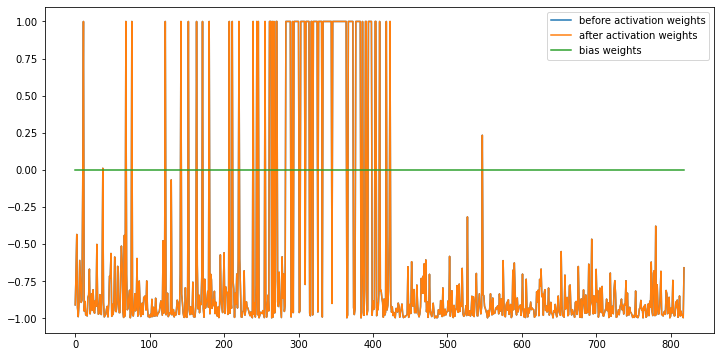

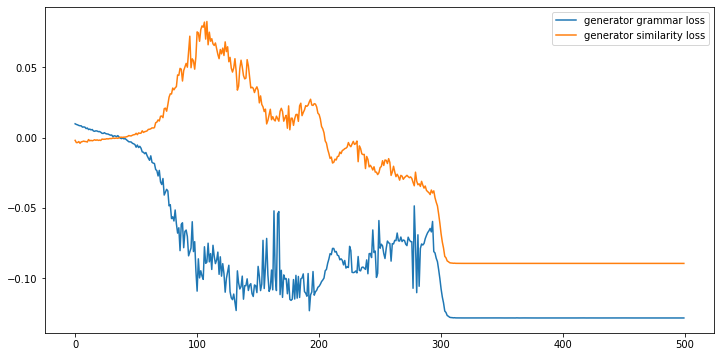

--------------------------------------------------
gold summary:
Labrador-Chow mix reportedly destroyed at Bakersfield animal shelter .
Eight-month-old 'Scrappy' was filmed attacking four-year-old neighbour .
Dog viciously shook Jeremy Triantafilo by the leg until pet cat intervened .
Tara the tabby pounced on Scrappy and chased him off down the street .
The dog continued to display aggression in the days after the attack .
He bit two staff at the animal centre and tried to attack several others .
--------------------------------------------------
sam_wgan summary:
be the best as he period staff any Wednesday, with was a pretty a take there, not even know hit Feline cat launches And dont come back! Tara follows the make it has left, before returning to check explained that she had been near the house watering a tree neighbors dog, escaped and grabbed her son by leg. never seen a dog shake a child like that so violently, she said. I just remember him and the next thing I know, I see my 

Unexpected error: <class 'IndexError'>
27 / 50
------------------------------------------------------------------
The boss of HSBC was last night facing questions over his secretive tax affairs after claiming he sheltered money in a Swiss bank account to prevent prying colleagues from finding out his bonus. Speaking publicly for the first time since revelations about HSBC’s Swiss private bank, Stuart Gulliver described his ‘shame’ at allegations that the lender routinely helped clients including arms dealers and blood diamond smugglers evade taxes. But he was also forced to defend his own finances after leaked documents revealed he sheltered some £5million in bonuses in an HSBC account in Switzerland under the name of a Panamanian company. Leaked files reportedly show that Stuart Gulliver (pictured), chief executive since 2011, held £5million in the banks Geneva-based subsidiary that was at the centre of a huge tax avoidance scandal. This lasted from 1998 until 2011, when he became chi

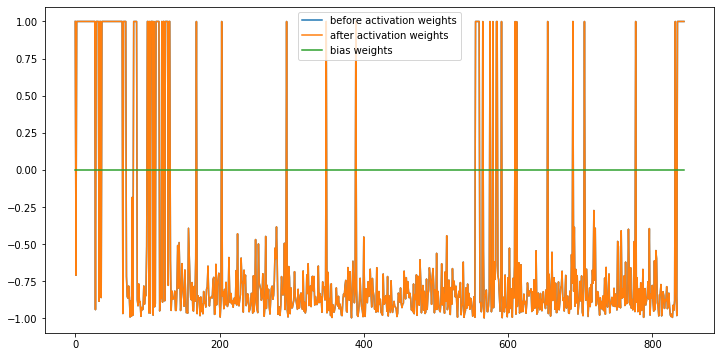

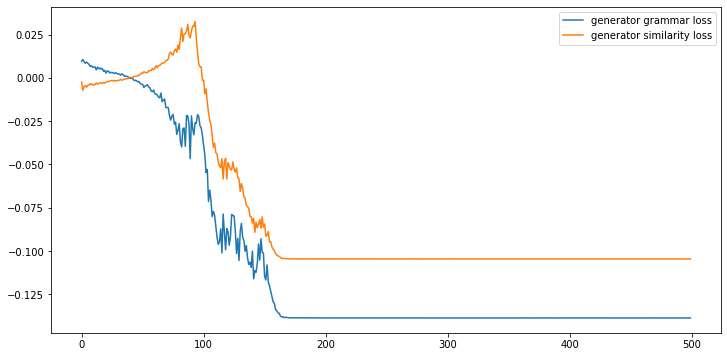

--------------------------------------------------
gold summary:
Stuart Gulliver's bonuses allegedly paid via Panama-registered company .
Money put in Swiss account until 2003, leaked documents reportedly show .
Mr Gulliver said this was the only way to hide earnings from colleagues .
Claims without Panama business others in bank could search for earnings .
He said: 'It was to enable confidentiality. There was no tax advantage'
Derby-born boss, 55, is domiciled in Hong Kong for legal and tax purposes .
Comes after it emerged that Swiss HSBC Private Bank helped rich avoid millions in tax .
--------------------------------------------------
sam_wgan summary:
 boss of HSBC was last night facing questions over his secretive tax affairs after claiming he sheltered money in a Swiss bank account to prevent prying from finding out his Speaking publicly the first time since revelations about HSBC’s Swiss private bank, Stuart Gulliver described his ‘shame’ at allegations that the lender routinel

Unexpected error: <class 'IndexError'>
28 / 50
------------------------------------------------------------------
They were intended to be ‘Tapes from Beyond the Grave’ – explosive interviews with former IRA terrorists revealing some of their most notorious crimes. The interviews, recorded for a history project, were granted only under strict condition that they were not released until after the deaths of all concerned. But after a fierce legal battle, the secret interviews were passed to the police in Northern Ireland – and the bombshell revelations contained on the tapes are thought to be a key factor behind the dramatic arrest and questioning of Gerry Adams at a police station in Antrim yesterday. Former friends: Gerry Adams (left) is pictured in Long Kesh prison with Brendan Darkie Hughes, a former deputy commander of the IRAs Belfast Brigade. Hughes said Jean McConville was killed on Adams orders. Murdered: At least two high-profile IRA operatives have linked the Sinn Fein leader 

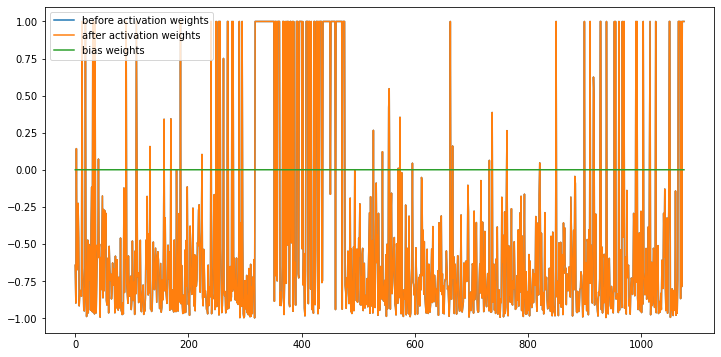

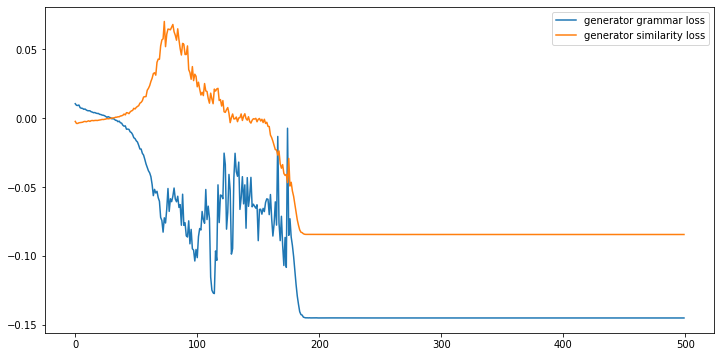

--------------------------------------------------
gold summary:
Interviews not supposed to be released until after deaths of all concerned .
But after a legal battle, secret tapes passed to police in Northern Ireland .
They are thought to be key factor behind arrest of Gerry Adams in Antrim .
At least two IRA operatives link Adams to the murder of Jean McConville .
Mother of ten was brutally abducted, executed and secretly buried in 1972 .
Ex-IRA terrorists who claim they served with Adams say he ordered killing .
But Sinn Fein leader has repeatedly denied any involvement in the murder .
--------------------------------------------------
sam_wgan summary:
explosive revealing project, under Gerry Kesh of informers streets, buried. tapes and claims which 65-year-old and denied or include two damning accounts – one of which was given by ex-hunger. striker Brendan ‘Darkie’ Hughes, a former deputy commander of the IRA’s. who died in 2008, said McConville was killed on Adams’ orders. only o

Unexpected error: <class 'IndexError'>
29 / 50
------------------------------------------------------------------
Rush Limbaugh has apologised for calling a college student a slut after she argued that employers should pay for their workers contraception. The controversial radio hosts comments, which included a suggestion that Sandra Fluke should make a sex tape, caused a row which saw him abandoned by advertisers and even drew in Barack Obama. But today he acknowledged that he chose the wrong words while trying to illustrate the absurd with absurdity, and insisted: I did not mean a personal attack on Ms Fluke. Rant: Rush Limbaugh, 61, left called Sandra Fluke, right, a student at Catholic college Georgetown University, a slut for saying religious institutions should cover birth control under health insurance. Mr Limbaugh had faced repeated calls. for an apology after claiming that the student must be sexually. promiscuous because she supported a contentious measure which would have. f

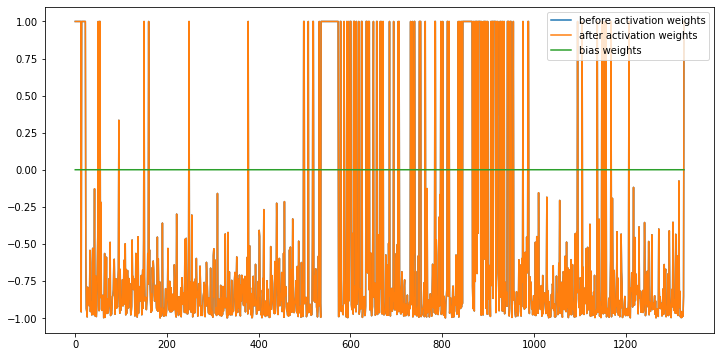

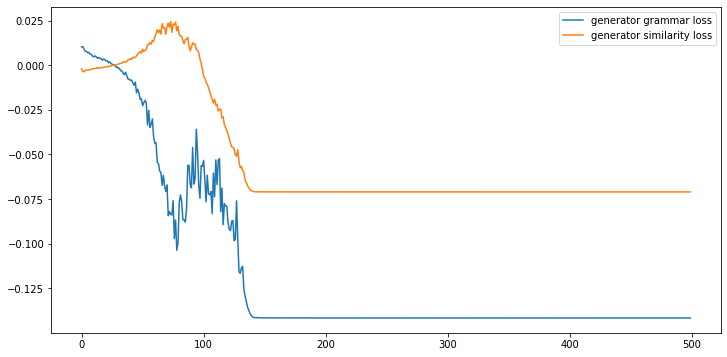

--------------------------------------------------
gold summary:
Conservative radio host slammed Georgetown University's Sandra Fluke .
Three advertisers had pulled out in response to controversy .
Obama said comment was 'reprehensible' and called Fluke to discuss it .
--------------------------------------------------
sam_wgan summary:
 Rush Limbaugh has apologised for calling a college student a slut after argued that employers should pay for their workers contraception. even Barack Obama. rhetoric, sex He immediately made fun cover a further Mattress and Sleep Number, as well as mortgage lender QuickenLoans, have all. bowed to pressure on Twitter and said they will no longer advertise on. ‘We dont condone negative comments. directed toward any group,’ a Sleep Train spokesman tweeted. do not Number. immediately said: inflammatory comments - clients & team has Meanwhile re-evaluate’ its will look into of buys’. Fluke, Washington D. medical And further contraceptives we can watch. subj

Unexpected error: <class 'IndexError'>
30 / 50
------------------------------------------------------------------
(CNN) -- Do you suffer from FOMO (otherwise known as fear of missing out)? Does the idea that some infinitely intriguing person/place/thing is currently flitting through your general sphere of being -- WITHOUT YOUR KNOWLEDGE -- cause your heart to constrict with terror? Well, friends, we hear you. Having just returned from the liquor- (and other liquid-) soaked climes of Austin and SXSW, were pretty sure we only experienced about 1. 3% of all Cool Things present at that havoc-wrecked fest. Basically, all we gathered was that people really like Skrillex, and, mysteriously, Train (thanks Monstro!) and that the most-flogged apps at SXSW Interactive were undoubtedly those who aim to kill FOMO dead. Enter: Sonar, Highlight and Banjo, a new wave of social apps designed to keep you abreast of all the interesting people around you -- without requiring that you look up from your sma

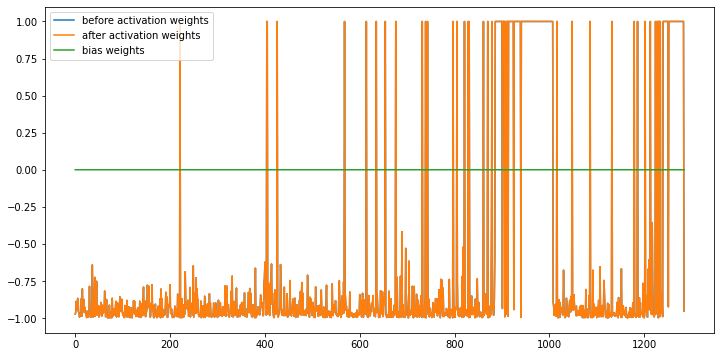

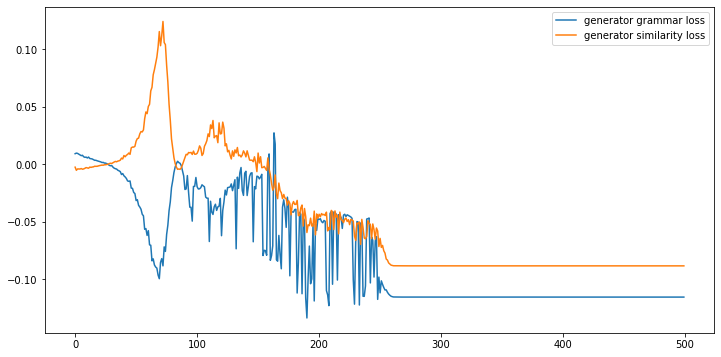

--------------------------------------------------
gold summary:
Sonar, Highlight and Banjo are a new wave of social apps that were all the buzz at SXSW .
Sonar shows who is chilling at hot spots near you and who you might be interested to meet .
Highlight alerts you when people who share your interests are nearby .
Banjo lets you see whatever content -- tweets, photos, etc. -- nearby users are sharing .
--------------------------------------------------
sam_wgan summary:
phone, networks (Facebook, youll your course, cruise latest from Facebook, interests there and keen equivalent site a initial Meet doll Seriously, how much can one stretch ones imagination when it comes to weaving background stories inanimate objects? And QVCs arent any If only could discover some brand new friends -- complete with dossiers (like books that come with those American Girl dolls) -- with whom to maybe, possibly, but not likely hang out with. Well, youve got a friend in Banjo! Banjo serves two purposes: I

Unexpected error: <class 'IndexError'>
31 / 50
------------------------------------------------------------------
Chelseas early season form may have led to comparisons with the Arsenal Invincibles side, but Gary Neville believes they arent even as good as the Chelsea side from 10 years ago. Jose Mourinhos side are currently four points clear at the top of the Premier League, but after letting leads slip against both Manchester City and United, their killer instinct has been called into question. If a team are going to be playing for a 1-0 then you better see it out, Neville said on Monday Night Football.  When I saw Jose Mourinho two weeks ago he talked about the 2005 (Chelsea) team and (compared) the team he had then to the team he has now and he said the killer instincts missing. Chelsea have dropped more points from winning positions this season than they did in the whole of 2004/05. Chelsea took the lead against both Manchester United and Manchester City, but drew both matches. Wh

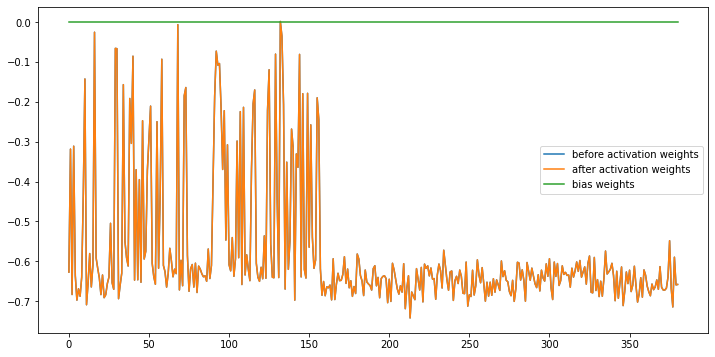

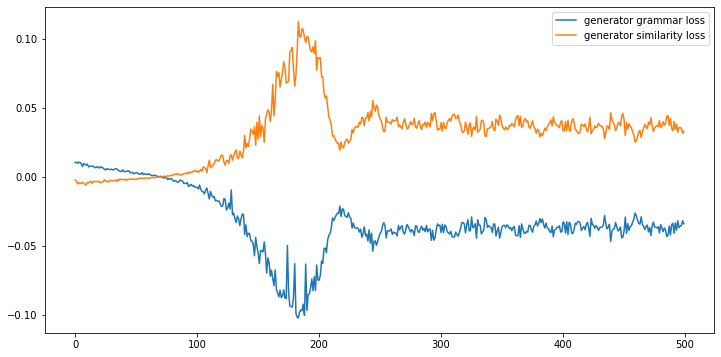

--------------------------------------------------
gold summary:
Chelsea are four points clear at the top of the Premier League .
Jose Mourinho's side have proved themselves to be early title favourites .
But Gary Neville believes there is still room for improvement .
The former Manchester United defender criticised their lack of killer instinct .
Chelsea dropped points against both Manchester clubs .
--------------------------------------------------
sam_wgan summary:
Chelseas season comparisons with Gary Chelsea 10 years side points clear at top the League, letting leads slip City United, their team be playing I saw Jose Mourinho two weeks ago he about (compared) team had he has now Chelsea have from winning this season than did whole of Chelsea took the against United Manchester both matches.
--------------------------------------------------
32 / 50
------------------------------------------------------------------
As Burberry today unveils its new spring/summer campaign in store w

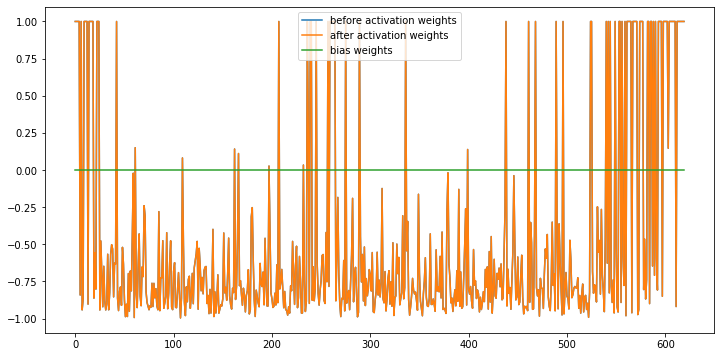

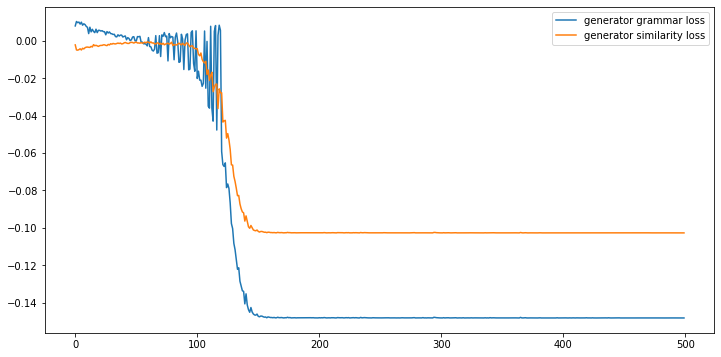

--------------------------------------------------
gold summary:
Brand has 10,163,728 fans on Facebook while 694,495 follow UK Twitter feed .
Chief creative officer Christopher Bailey personally thanks followers .
New films star Burberry faces Eddie Redmayne and Cara Delevingne .
--------------------------------------------------
sam_wgan summary:
 As Burberry today unveils new in store windows and social media networking sites, millions will be watching. fashion fans, two shots. All fans connected. is really involved, Burberry told MailOnline. very inclusive. tiny man can remains out has With Marilyns Summer collection the media has over Facebook and About the videos, Bailey says: wanted to capture a moment lives of two exciting who have part of Burberry for The images reflect the of the collection through Eddies Caras energy, playfulness and effortless elegance and have such huge admiration for them both. 
--------------------------------------------------
bert_lexrank summary:
stric

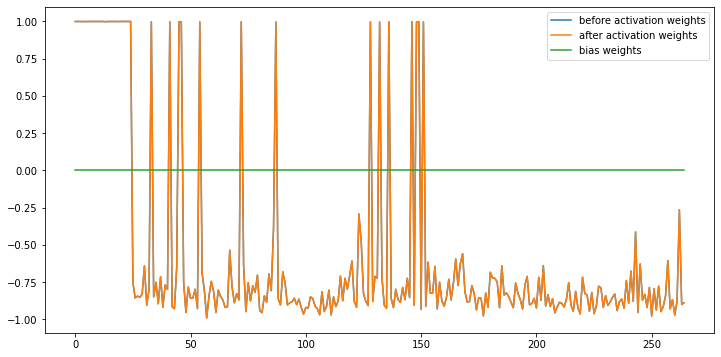

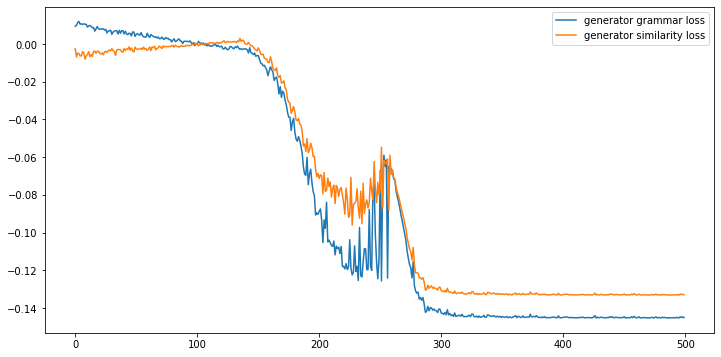

--------------------------------------------------
gold summary:
Two men filmed taking iPad from canoe rental office in Florida .
One checks coast is clear before putting computer in other one's bag .
After swiping the device they make their getaway in a kayak .
--------------------------------------------------
sam_wgan summary:
 Police are hunting for two thieves in Florida who stole an iPad from a canoe rental office before making their getaway in a kayak. the front canoe rental his kayak iPad is with dark tank and black shorts.
--------------------------------------------------
bert_lexrank summary:
blue horizontally striped tank top, and black plaid shorts.According to deputies one suspect is a. Hispanic man with a partial goatee, dark colored hair, a blue and light.But now they are being hunted by Seminole County deputies, who think they could have been rowing toward Wekiva Springs State Park.He took the iPad from the front desk before going to the bathrooms and meeting with anot

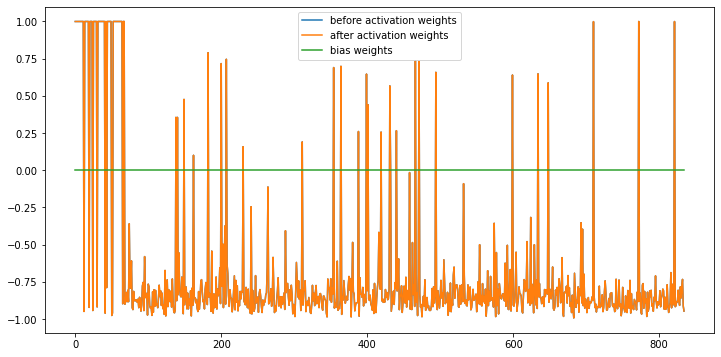

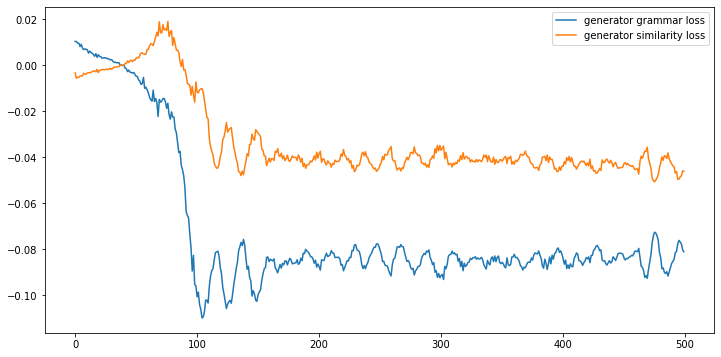

--------------------------------------------------
gold summary:
Lukan Faily said Monday that while Obama frets about Iraq's internal politics, ISIS is gathering strength .
Unless the group is stopped, he said, it will become a global terror threat like 'a thousand' Bin Ladens .
ISIS will take 'no POWs,' he warned, 'nothing, none of that. No rules of engagement but destruction'
'What we have in Iraq now ... is an immediate threat,' the ambassador warned .
CNN's Christiane Amanpour said she thought the true threat was a Sunni minority that feels 'disenfranchised'
ISIS, the Islamic State in Iraq and Syria, is a Sunni militant group that was previously known as 'Al-Qaeda in Iraq'
--------------------------------------------------
sam_wgan summary:
 The Sunni extremists running roughshod across Iraq could produce a thousand terrorists like Osama bin Laden bent widespread death and destruction, ambassador to the United States on Monday. Lukman Faily said that if the United States other focu

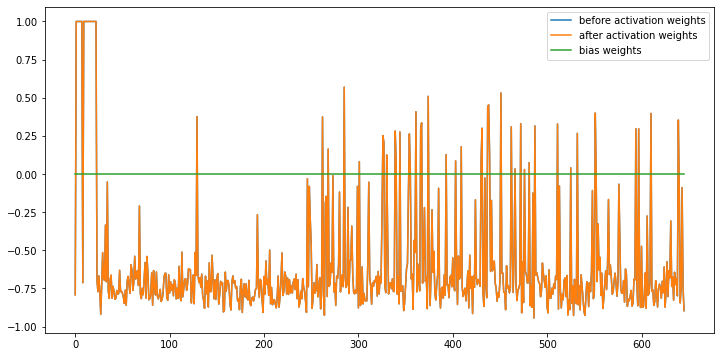

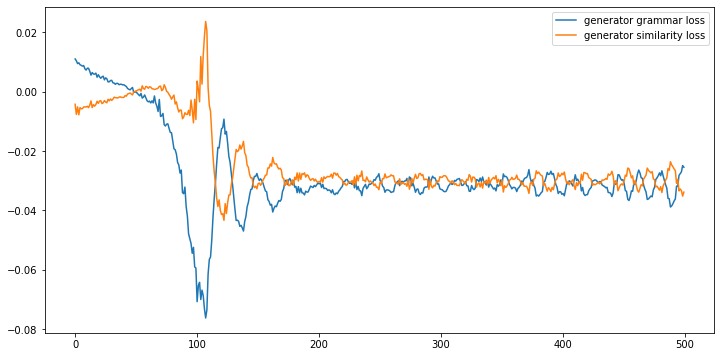

--------------------------------------------------
gold summary:
Hammond warns against complacency in the fight to disrupt terror plots .
Foreign ministers from across the globe fly into London for talks .
They will discuss plan to take on jihadis and prevent Paris-style attacks .
David Cameron promises the UK will do 'everything we can' to help Iraq .
--------------------------------------------------
sam_wgan summary:
Britain is at very significant risk from terror attack by extremists inspired by ISIS jihadis, Foreign Secretary Philip Hammond warned today. he against the the Mr Group the Global meeting, stressed the of UK Iraq to probably immediate at moment, significant in intercepting it, Isil sympathisers inspired by on and intelligence agencies, tirelessly monitor, to intercept plots and so, there we we before of an Cameron Prime Minister Haider in Mr stop foreign join mayhem Iraqs not ready spent the following had he BBC Radio Today - be and had to armed do be ready that
------

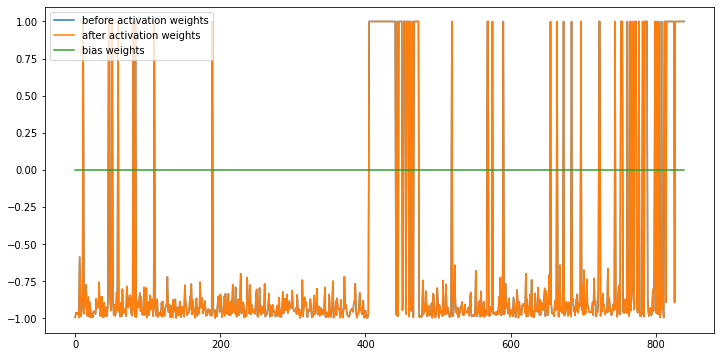

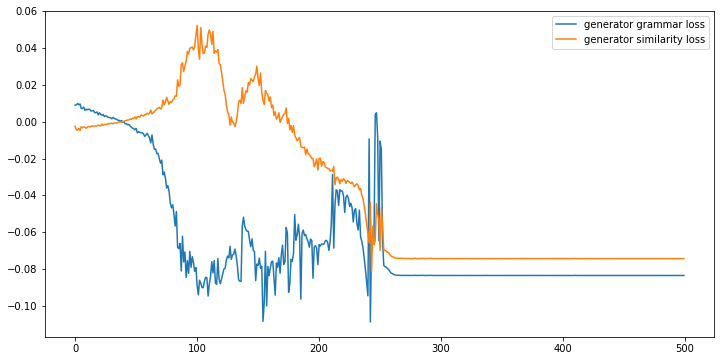

--------------------------------------------------
gold summary:
Organisers defend 'barbaric' event as 'perfectly legal'
Video footage shows children battling on the floor without head guards .
Culture Secretary Jeremy Hunt condemns the underage contests .
Child safety experts call for ban and urge social work to be brought in .
Council to ask club not to stage any more such events involving children .
--------------------------------------------------
sam_wgan summary:
cage sport – by club conditions. come front eight-year-old Association of Martial Arts spokesman insisted: ‘Children this young. shouldn’t be involved in cage fighting. ’ Lancashire Police officers have decided to take no further action either on a child safety level or licensing of the premises. last however, that council chiefs have licence review for Greenlands Labour Club will ask not. put on any similar events involving juveniles. I pair begin the a Kian or receiving Fight: each fortnight ago the the company commis

Unexpected error: <class 'IndexError'>
37 / 50
------------------------------------------------------------------
Two women accused of drug smuggling in Peru could serve their sentences in the UK if Britain agrees to a transfer, Peruvian prosecutors said. Melissa Reid and Michaella McCollum, 20, were found with £1. 5million worth of cocaine in their suitcases as they tried to check-in for a flight from Lima to Madrid, on August 6. The women claimed they were kidnapped in Ibiza and forced to carry the drugs by gun-toting Colombian gangsters who threatened them and their families. Indication: The two women accused of drug smuggling might enter guilty pleas to secure transfers to UK jails. But this week, they suggested they would plead guilty in order to secure shorter sentences, after conceding that detectives did not believe their story. They are expected to receive a sentence of six years and eight months if they admit drug trafficking at their next court hearing. Now, Peruvian counter

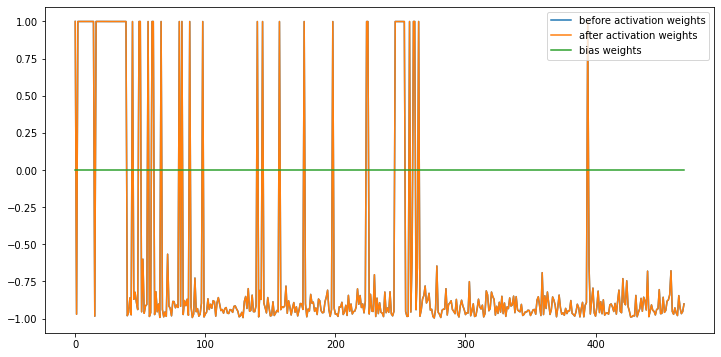

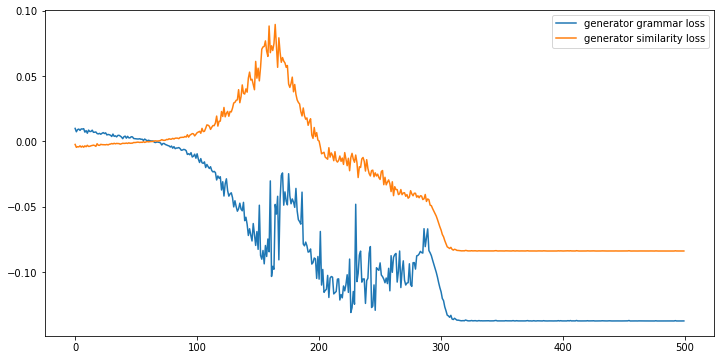

--------------------------------------------------
gold summary:
The pair have suggested they might plead guilty to reduce sentences .
They face more than six years behind bars if they do admit trafficking .
Under a deal with the UK they could be transferred to British prisons .
The two Brits were caught with £1.5million of cocaine in their suitcases .
--------------------------------------------------
sam_wgan summary:
 women accused of drug smuggling in Peru could serve their sentences in the if Britain agrees to a transfer, Peruvian prosecutors said. Melissa Reid and Michaella McCollum, 20, were found with £1. 5million worth of cocaine in tried flight from 6. claimed they forced families. The smuggling jails. trafficking court could in UK told the two-and-a-half years of a six-year-and-eight-month sentence, after which. apply their parole anyway. dire
--------------------------------------------------
bert_lexrank summary:
The source said: The process is very slow.A.Pictured here on

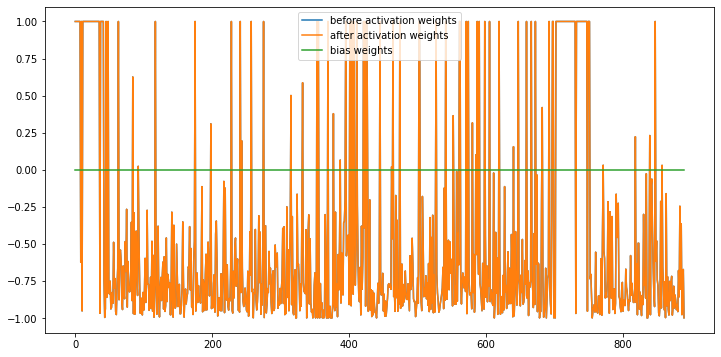

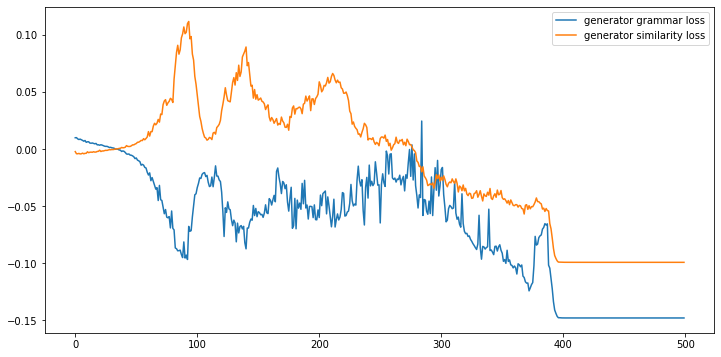

--------------------------------------------------
gold summary:
Frank Henderson, 60, only found out he had cancer two weeks ago .
Frank has always been a fan of Christmas and usually puts up the lights .
Neighbors all joined in with the festive celebrations in a show of solidarity .
--------------------------------------------------
sam_wgan summary:
 A neighborhood have held Christmas early for father has just weeks to live after an unexpected diagnosis. Frank Henderson, 60, Shoreline, Washington, only found out he had cancer two weeks ago and has given a fortnight to live. family in September. of few that worry then as Bucket and Christmas once and his of period, own that would chance donated who brought dance with They little sort of just and with children one one his each was, then But examples, and then The Henderson family have been contacted by people across the world who have been inspired by their story. His daughter Thea wrote on Facebook: My Dad has a 1 a kind spirit. He is

Unexpected error: <class 'IndexError'>
39 / 50
------------------------------------------------------------------
Marine experts today warned people not to enter the water after. two killer whales were spotted 100 yards off the English coast. predators were described as unpredictable and could attack surfers and bathers. A mother and calf were spotted off the coast of. Padstow, Cornwall - just 15 miles from the surfing mecca of Newquay - and experts. warned the giant whale may inadvertently harm a human or attack while protecting its. A mother and calf were spotted off the coast of Padstow in Cornwall and experts warned the giant whale may inadvertently harm a human or attack while protecting its young (library image of an Orca in Scotland) Peter Richardson, of the Marine Conservation Society, said: Obviously we wouldnt recommend getting into the water with a killer. are enormous super predators and are therefore unpredictable. is a pod of killer whales in Scotland and they could be tr

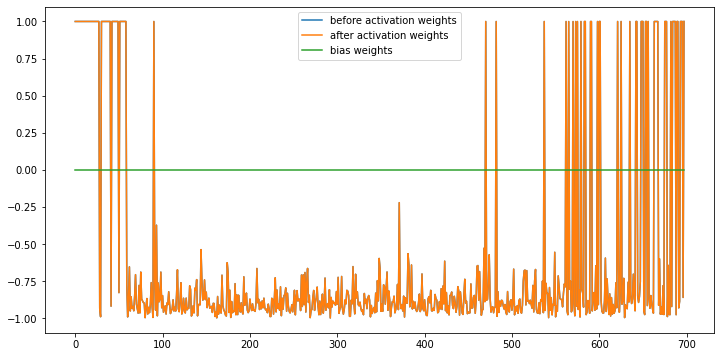

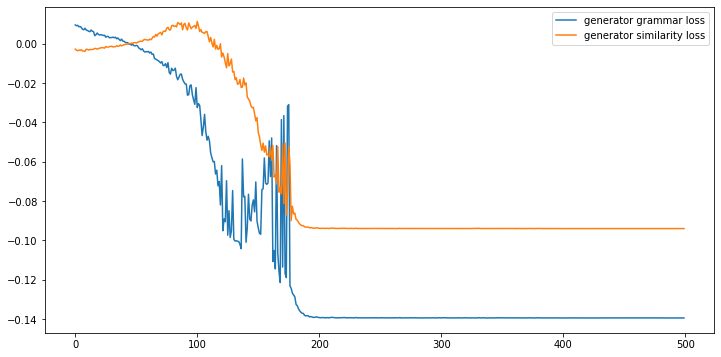

--------------------------------------------------
gold summary:
Sightings at Padstow, just 15 miles from surfing mecca of Newquay .
--------------------------------------------------
sam_wgan summary:
 Marine experts today warned people not to enter the water after. two killer whales were spotted 100 yards off the English coast. predators were described as unpredictable attack surfers and bathers. A mother and calf were spotted off coast of. Padstow, Cornwall - just 15 miles the surfing mecca of Newquay - and experts. giant Cornwall whale from Trevose,. pod while in cliff-top. runs and education that the there be a the Angie said through the more northerly waters There is evidence whales in Cornish waters and Basking sharks are huge off the Cornish coast the summer a familiar sight 
--------------------------------------------------
bert_lexrank summary:
see, so I grabbed the binoculars, he said.In September last year, a holidaymaker at.Mr Clarke told how he came across a man with bin

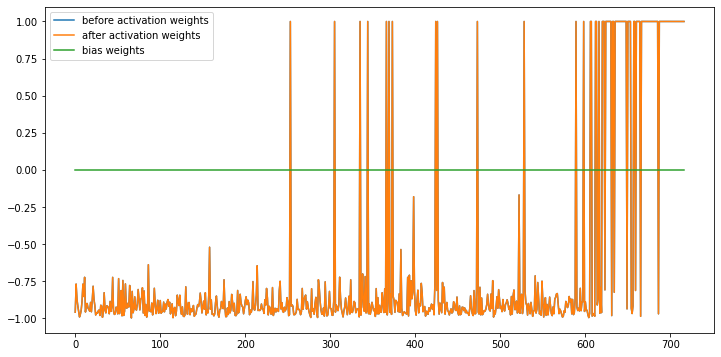

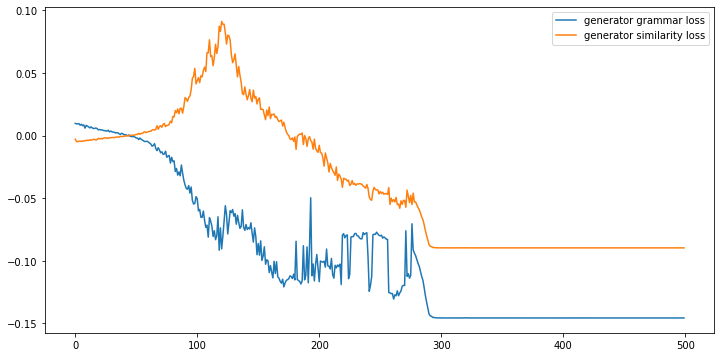

--------------------------------------------------
gold summary:
Rachel Ann Nunes  filed a federal lawsuit against teacher Tiffanie Rushto .
Claims Rushton cut and pasted sections from electronic copy of her book .
Rushton insists the idea came from a friend who died in a car wreck .
--------------------------------------------------
sam_wgan summary:
me after for says contained in six overt and romance didnt After up She alleges different profiles attempt Nunes is seeking least $150,000 in damages as well as fees in suit, which was first reported by the Ogden Standard-Examiner. Since filing it, Nunes says heard from other authors also been from their e-books. The books often pulled when the plagiarism is identified but later reposted under a different name. online, you can be so anonymous, said. How many authors can afford to take someone to court? Thats your life savings, thats your whole future. Sorry we are not currently accepting comments on this article. 
------------------------

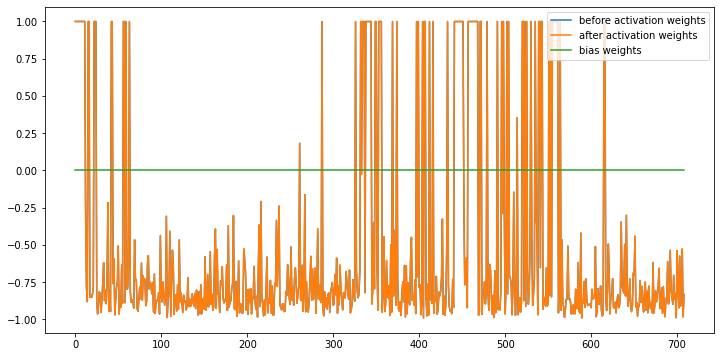

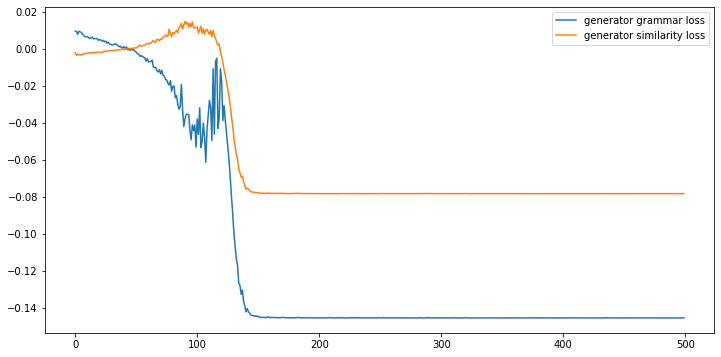

--------------------------------------------------
gold summary:
Sergeant Andy Sharp was snapped escorting protesters in central London .
Recruits have to pass fitness tests when they join but no requirements for non-specialist officers to complete tests once they are in the job .
--------------------------------------------------
sam_wgan summary:
 It brings a new meaning to the phrase ‘heavy police presence’. was at about physical fitness to defend his force. the struggle. and senior officers basic safety training ‘so unfit they cannot. complete the warm-up fitness equipment. installed in stations or on given being But cases, because officers mean fit test strength (Dynamic Strength Test or Push-Pull)You should wear gym shoes and test. (1) The multi-stage shuttle run test (Bleep Test)This is done first. run back 15 increase until reach The required level. You likely pass 1. minutes a treadmill 8 mph Dynamic Test test is carried out on a Concept machine. 35kg (pull).
-----------------

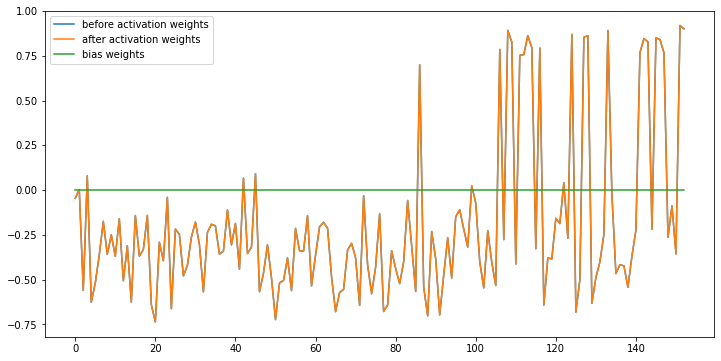

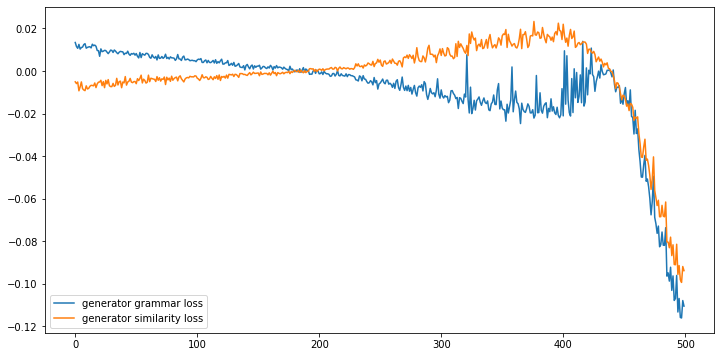

--------------------------------------------------
gold summary:
Muqtada al-Sadr has been in Iran since 2007 .
He's been studying to be an ayatollah .
His political bloc was a kingmaker after elections in March .
--------------------------------------------------
sam_wgan summary:
fall now forces with former rival, Prime Minister al-Maliki. the Iraqi politics won a major role al-Maliki getting his office. 
--------------------------------------------------
bert_lexrank summary:
The Shiite cleric has been in Iran since early 2007, apart from a public appearance in Iraq in May 2007.He has been studying in the Iranian city of Qom to become an ayatollah, the title given to high-ranking Shiite Muslim religious scholars.Al-Sadr commanded one of Iraqs most formidable private armies after the fall of Saddam Hussein, which contributed to violence and instability in the country for several years.His political bloc has now joined forces with a former rival, Prime Minister Nuri al-Maliki.The Sadr 

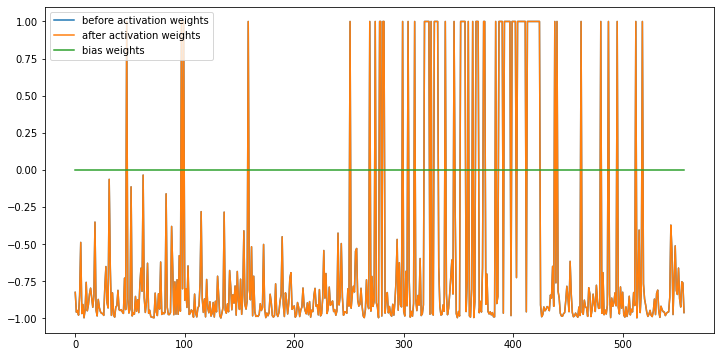

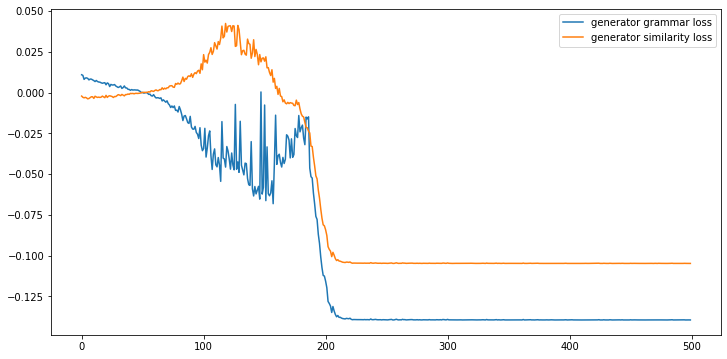

--------------------------------------------------
gold summary:
Dmitry Medvedev blasted Obama for not 'know[ing] how to make reserved, careful, subtle, wise and intelligent decisions'
A more 'competent politician,' he said, wouldn't have slapped Russia with economic sanctions after it marched across the Ukraine border .
'We probably could cause some unpleasantries for the country that imposes those sanctions,' he hinted in a moment ripe for The Sopranos .
The interview came as state-run TV reported that Russian soldiers near Ukraine are standing down and returning to their bases .
--------------------------------------------------
sam_wgan summary:
in smile! for March unpleasantries with Clinton Medvedev said Obama administration that more issues, Vladimir Putin joined with Chinese Xi to oversee joint naval powers of Medvedev hinted at repercussions for sanctions, probably some unpleasantries for those sanctions agreements reached with America were And Im very sorry that everything ha

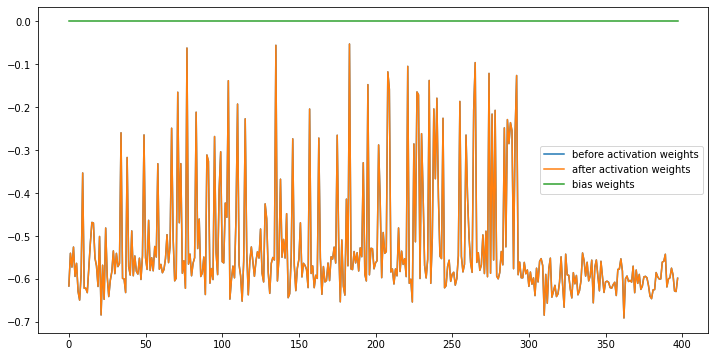

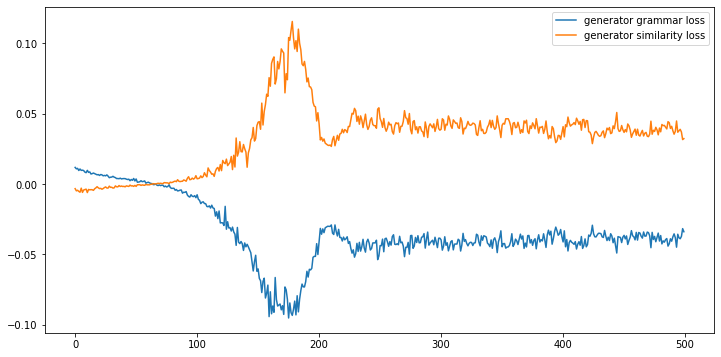

--------------------------------------------------
gold summary:
Gang in St Louis, Missouri, dragged Bosnian woman from car, said: 'You're Bosnian. I should just kill you now'
It comes five days after Zemir Begic was hammered to death in the city .
FBI called in to investigate the case as a hate crime .
--------------------------------------------------
sam_wgan summary:
her crime a victim, teenagers pulled ordered to 26-year-old the in the the a crowbar pulled out to through she and Youre They the opted Killing: said early when car beating him at to Begic in St Louis reported St Louis police FBI five Begic, resident of wife around 15am of approached his car and vandalizing it.
--------------------------------------------------
45 / 50
------------------------------------------------------------------
From terrifying roars to anguished snarls and evil laughs, it can instantly transform any actors voice into a monsters. This incredible software was created by Orfeas Boteas, 27, during a

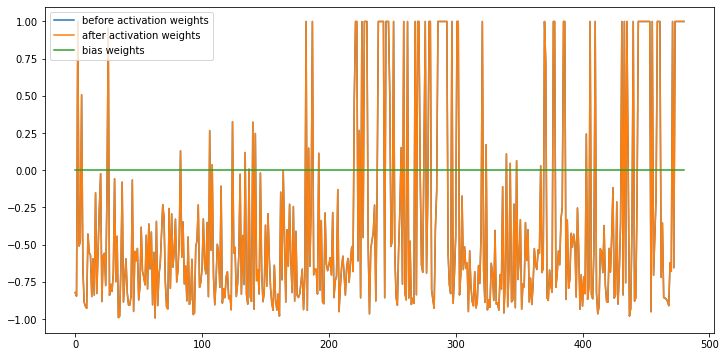

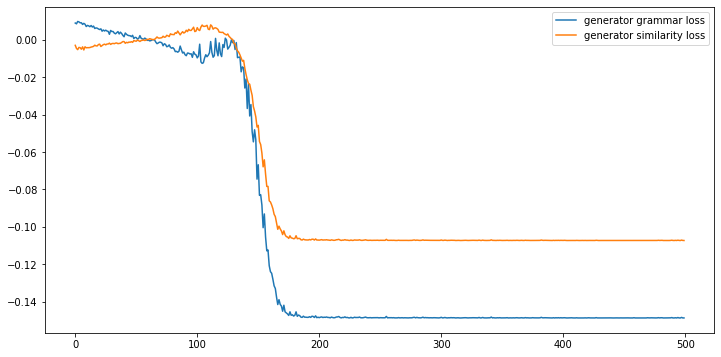

--------------------------------------------------
gold summary:
Software was created by Orfeas Boteas, 27, at the University of Edinburgh .
Dubbed 'the Dehumaniser', it can transform actors' voices into monsters'
It has created unique sounds for array of TV series, films and video games .
These include drama Sleepy Hollow and Animal Planet's Finding Big Foot .
--------------------------------------------------
sam_wgan summary:
terrifying voices with Dehumaniser lets real said Mr Boteas, also been used in many series, feature films worldwide. came the creating prototype of received phone calls calls from film, TV and video game professionals. demonstration started showing. Boteas, professionals version - have praised In he Avenue and Planets settings I had a laugh looking through them. Mr Boteas offers Lite software for £49, was the Encouraging Dynamic Growth Entrepreneurs 2014 award. 
--------------------------------------------------
bert_lexrank summary:
former student, who is orig

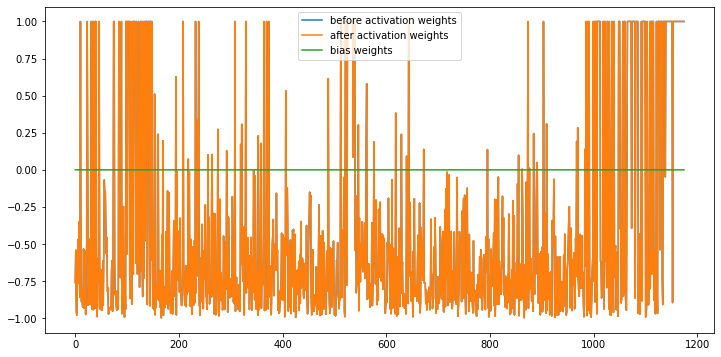

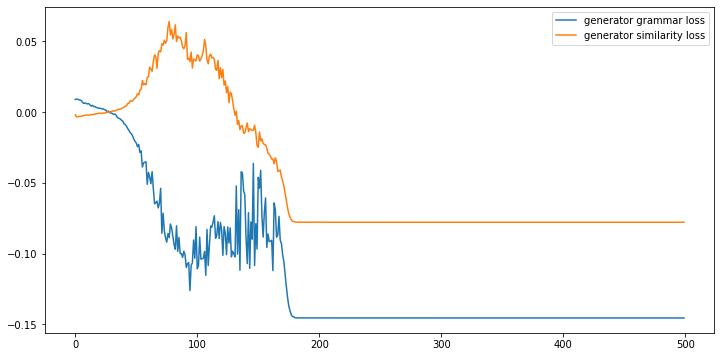

--------------------------------------------------
gold summary:
Netherlands, Belgium and Qatar all had monarchs step down in 2013 .
King Juan Carlos I of Spain announced Monday he would abdicate .
Royal watcher says there's no chance Queen Elizabeth would give up throne .
--------------------------------------------------
sam_wgan summary:
savor Its against the perks a king job to hand in that four decades. son, Crown Prince Felipe, take King one of several step years. Queen Beatrix passed crown son Prince Willem-Alexander. had been ruling more than decades. Netherlands following Beatrixs to Philippe, in Pope keep in Sheikh Hamad bin Al Thani, the Emir of Qatar, abdicated and transferred power to son in 2013. as took showed I thought rule and and you will see it in the United Kingdom. that the job was given by can Williams critical to a Britain, But its U. Theres no way Queen Elizabeth doesnt consider shock waves sent through British society King Edward VIII abdicated in Fitzwilliams 

Unexpected error: <class 'IndexError'>
47 / 50
------------------------------------------------------------------
A woman whose nose and upper lip were bitten off by mice when she was a baby is to receive free plastic surgery. Zhu Sanni, 23, from Qingdao, Shandong Province, had been left alone at home for three days when the animals began to eat her face. Her father suffered from a mental illness and often left home and disappeared for days. Fresh chance: Zhu Sanni, 23, had been left alone at home for three days when the animals began to eat her face. Sanni was left to survive by herself but when she was discovered her face was covered in blood and her nose and lip had been eaten by mice. One day her mother went out for food but did not return for three days. Sanni was left to survive by herself but when she was discovered her face was covered in blood and her nose and lip had been eaten by mice. Without money, her parents didnt take her to the hospital, but simply washed her wounds. R

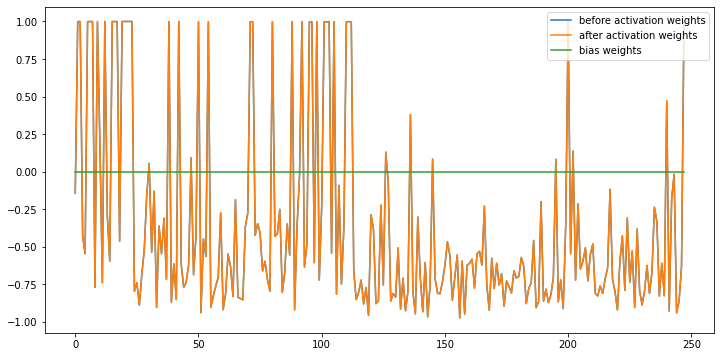

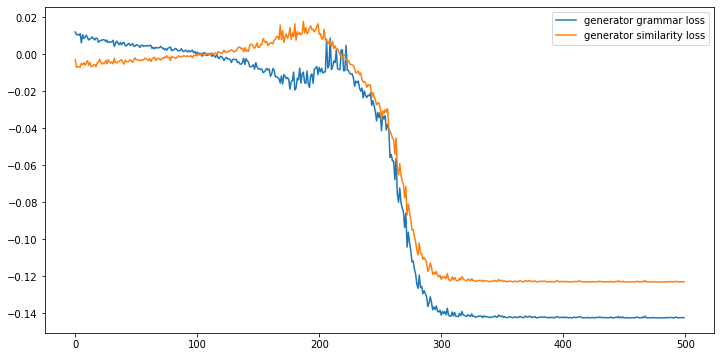

--------------------------------------------------
gold summary:
Zhu Sanni, 23, had been left alone at home for three days when it happened .
Her father suffered from a mental illness and often left home .
Mother went out for food and did not return for three days .
--------------------------------------------------
sam_wgan summary:
A woman and upper lip bitten mice was a baby to receive free plastic surgery. three animals suffered illness alone at began to but was discovered face in blood and nose eaten by mice. artificial 
--------------------------------------------------
bert_lexrank summary:
Recently Qingdao Boshi Hospital has offered to provide free surgeries for Sanni.One day her mother went out for food but did not return for three days.Without money, her parents didnt take her to the hospital, but simply washed her wounds.Staff found the 89-year-old covered in blood and the man was in a distressed state and had injuries from severe mouse bites.Director Wu Yuhua from the medic

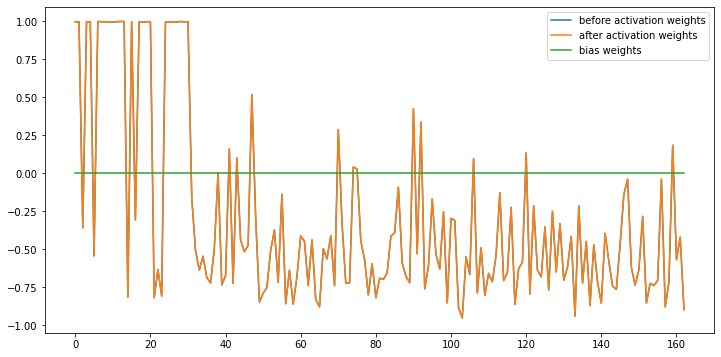

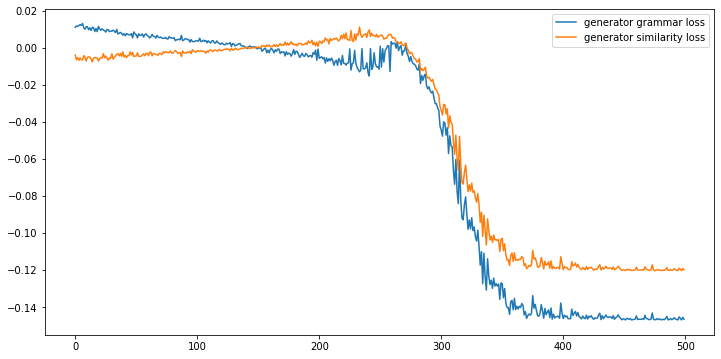

--------------------------------------------------
gold summary:
Official: Bottles are almost exclusively from "Afghan sources" and not foreigners .
Alcohol is largely banned in Afghanistan .
Certain areas, however, that cater to foreigners are permitted to sell it .
--------------------------------------------------
sam_wgan summary:
 Kabul, (CNN) -- of bottles of alcohol were destroyed in Kabul week, what authorities described as a crackdown on illegal smuggling and sales.
--------------------------------------------------
bert_lexrank summary:
Muslims, who constitute roughly 99% of the population.CNNs Matiullah Mati contributed to this report.Certain areas that cater to foreigners, however, are permitted to sell it.Zahir said that it was in these areas -- mostly international hotels -- that local sellers had come into possession of the alcohol.The illicit items were being stored by Afghan customs officials, who burned the bottles Wednesday after receiving authorization from the city

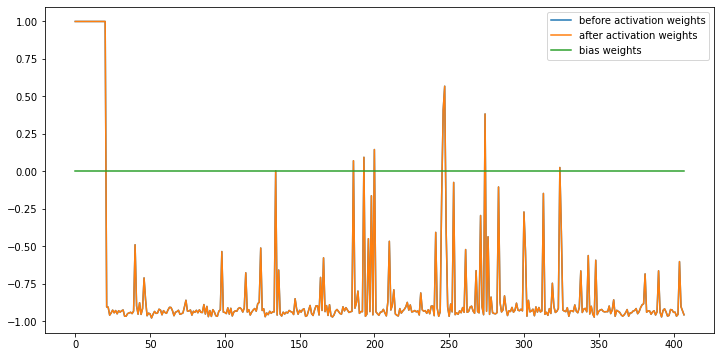

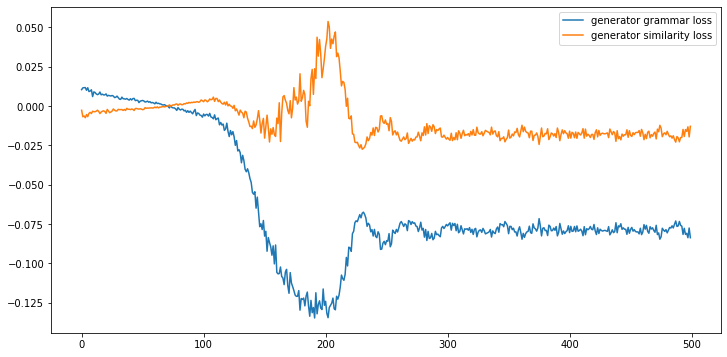

--------------------------------------------------
gold summary:
Two skeletons were found holding hands, buried at a lost chapel in Leicester .
11 skeletons have been found so far, but are yet to be analyzed .
Early findings suggest one died by being struck on the head with a pole axe .
Leicester was also the site where the remains of King Richard III were found .
--------------------------------------------------
sam_wgan summary:
 Even death couldnt part two skeletons excavated from a lost chapel in an English county, found with their fingers entwined. excavation overlooks some or head Another, says, a with idea -- possibly due a skulls where been buried together in main were thought may as pilgrimage, to the chapel special walls the site, Silver 12th clues where uncovered lived
--------------------------------------------------
bert_lexrank summary:
Another, she says, was in his mid-twenties, with teeth showing severe childhood trauma during the first nine years of his life.A team o

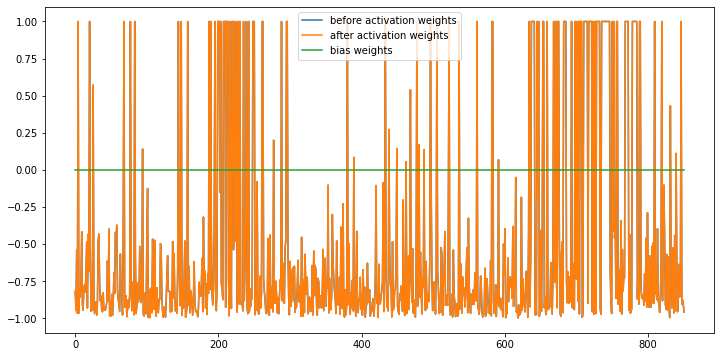

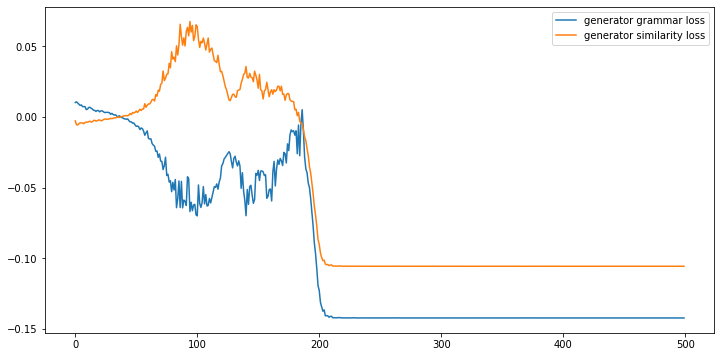

--------------------------------------------------
gold summary:
Danny Cevallos: Arrests over tweets threatening NYPD raise issue of when speech is threat .
He says Supreme Court to weigh in soon. Maybe it's time to draw threat line at social media .
--------------------------------------------------
sam_wgan summary:
Police reviewed violence rap songs. specifically Suppose going online, to rap out with its F*** those very lyrics. then were offended, But an album dont contain direct potential There nonspecific language cassette tape. And he had 13 on Twitter. access Court defendants statement of under understand media media threats that feel more like the unfiltered intent. protective free speech time again, in that perhaps social media, and the time threatening profane reprint Maybe the justices less inclined to equate the lyrics Eminem (as Justice John Roberts did) poetic of frighteningly abusive tweeters if more personal experience with social media. The NYPD confronts a similar pro

Unexpected error: <class 'IndexError'>


method  comp rate     intro      body  conclusion   isthmus  \
0      SAM+WGAN   0.150475  0.560141  0.415331    0.429411  0.013442   
1  BERT+LexRank   0.177940  0.317281  0.295077    0.289877  0.002859   
2          BESM   0.194700  0.618840  0.462896    0.448624  0.014435   
3   BESM+kobert   0.217048  0.618361  0.466098    0.437957  0.014212   
4   Transformer   0.138284  0.584039  0.424458    0.359838  0.014828   
5            T5   0.108427  0.576419  0.394838    0.317286  0.017439   

   simlirality  grammarity        R1        R2        RL  
0     0.450167    0.920913  0.274908  0.061459  0.158252  
1     0.299862    0.999889  0.208455  0.046928  0.124961  
2     0.490119    0.999974  0.305787  0.098814  0.190276  
3     0.492048    0.999958  0.317711  0.111909  0.196592  
4     0.441876    0.999978  0.441681  0.237426  0.315804  
5     0.414338    0.999922  0.409932  0.209598  0.303043

In [121]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

step = 0
for g_summ,intro,body,end in document:
    step += 1
    print("=" * 50)
    print(str(step),"/",len(document))
    print("=" * 50)
    
    org_text_1 = intro
    org_text_2 = body
    org_text_3 = end

    try:
        df1,dct1 = sam_wgan(g_summ,[org_text_1,org_text_2,org_text_3],display= True)
        if dct1['grammar'][0] > 0.0:
            df2,dct2 = bert_lexrank_sum(g_summ,[org_text_1,org_text_2,org_text_3])
            df3,dct3 = besm(g_summ,[org_text_1,org_text_2,org_text_3])
            df4,dct4 = besm_bert(g_summ,[org_text_1,org_text_2,org_text_3])
            df5,dct5 = abstract_method_1(g_summ,[org_text_1,org_text_2,org_text_3])
            df6,dct6 = abstract_method_2(g_summ,[org_text_1,org_text_2,org_text_3])

            test_result['SAM+WGAN'].append(get_features(dct1))
            test_result['BERT+LexRank'].append(get_features(dct2))
            test_result['BESM'].append(get_features(dct3))
            test_result['BESM+kobert'].append(get_features(dct4))
            test_result['Transformer'].append(get_features(dct5))
            test_result['T5'].append(get_features(dct6))
            result = pd.concat([df1, df2, df3, df4, df5, df6 ], ignore_index=True)
            #result = pd.concat([df1, df2, df3, df5, df6 ], ignore_index=True)
            
            print(result)
            
            print("Current result","=" * 50)
            print("Sample count:",len(test_result['SAM+WGAN']))
            print(get_test_statistics(test_result))
        
    except KeyboardInterrupt as ki:
        raise ki
    except:
        print("Unexpected error:", sys.exc_info()[0])
        pass

get_test_statistics(test_result)

## Reference

[1] Rada Mihalcea and Paul Tarau, (2004). TextRank: Bringing Order into Texts <br>
[2] G¨une¸s Erkan. (2004). LexRank: Graph-based Lexical Centrality as Salience in Text Summarization <br>
[3] Susan T. Dumais (2005). "Latent Semantic Analysis". Annual Review of Information Science and Technology. 38: 188–230. <br>
[4] Hans Peter Luhn (1960). Keyword-in-context index for technical literature. American Documentation, 11(4):288–295. ISSN 0002-823 <br>
[5] Aria Haghighi, (2009). Exploring Content Models for Multi-Document Summarization <br>
[6] Colin Raffel. (2020). Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer <br>
[7] Mike Lewis, (2019). BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension <br>
[8] Alec Radford, (2018). Language Models are Unsupervised Multitask Learners <br>
[9] Guillaume Lample, (2019). Cross-lingual Language Model Pretraining <br>
[10] Nils Reimers and Iryna Gurevych, (2019). Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks <br>
[11] Sharma, P., & Li, Y. (2019). Self-Supervised Contextual Keyword and Keyphrase Retrieval with Self-Labelling <br>
[12] Jacob Devlin, (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding <br>
[13] Ian J. Goodfellow, (2014). Generative Adversarial Nets <br>
[14] Yau-ShianWang, (2018). Learning to Encode Text as Human-Readable Summaries using Generative Adversarial Networks <br>
[15] Martin Arjovsky, (2017). Wasserstein GAN <br>